In [0]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=6063602bb7cd67491b45b09ab02ce37e27dbe7eccb6d70b3e088956dab3e7d7b
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN

Using TensorFlow backend.


In [0]:
%config InlineBackend.figure_format = 'retina'

In [0]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [0]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date, end=end_date)

[*********************100%***********************]  15 of 15 completed


In [0]:
data['Close'].head()

AUDUSD=X  CADUSD=X  CHFUSD=X  ...  PLNUSD=X  RUBUSD=X  SEKUSD=X
Date                                      ...                              
2016-02-01  0.706864  0.715676  0.976086  ...  0.245228  0.013256  0.116426
2016-02-02  0.711086  0.716846  0.980873  ...  0.247986  0.012943  0.117306
2016-02-03  0.702988  0.711238  0.981653  ...  0.248004  0.012545  0.116964
2016-02-04  0.715461  0.724942  0.994827  ...  0.251062  0.012999  0.118491
2016-02-05  0.719942  0.726998  1.006654  ...  0.253291  0.013026  0.119067

[5 rows x 15 columns]

In [0]:
data['Close'].describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [0]:
new_data.describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
# new_data['day'] = new_data.index.day
# new_data['month'] = new_data.index.month

In [0]:
values = new_data.values
values

array([[0.70686364, 0.71567619, 0.9760859 , ..., 0.24522787, 0.01325557,
        0.11642582],
       [0.71108586, 0.71684587, 0.98087299, ..., 0.24798575, 0.01294331,
        0.11730605],
       [0.70298767, 0.71123755, 0.98165292, ..., 0.24800359, 0.01254469,
        0.1169644 ],
       ...,
       [0.69463742, 0.7628929 , 1.01887989, ..., 0.26060671, 0.01608338,
        0.10633377],
       [0.69829965, 0.76491195, 1.02699983, ..., 0.26248854, 0.01611572,
        0.10722665],
       [0.70013791, 0.76566166, 1.03238595, ..., 0.26333806, 0.01613655,
        0.10701276]])

In [0]:
values.shape

(1019, 15)

In [0]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [0]:
scaled

array([[0.25593185, 0.0386939 , 0.0439291 , ..., 0.15635943, 0.1321969 ,
        0.5885236 ],
       [0.28590202, 0.04889107, 0.0861063 , ..., 0.19794154, 0.07479477,
        0.62116647],
       [0.2284193 , 0.        , 0.09297752, ..., 0.19821048, 0.00151777,
        0.6084964 ],
       ...,
       [0.16914749, 0.4503107 , 0.42097282, ..., 0.38823485, 0.65202737,
        0.21426368],
       [0.19514275, 0.46791172, 0.4925146 , ..., 0.41660833, 0.65797377,
        0.24737573],
       [0.2081914 , 0.47444773, 0.5399704 , ..., 0.42941713, 0.66180277,
        0.23944402]], dtype=float32)

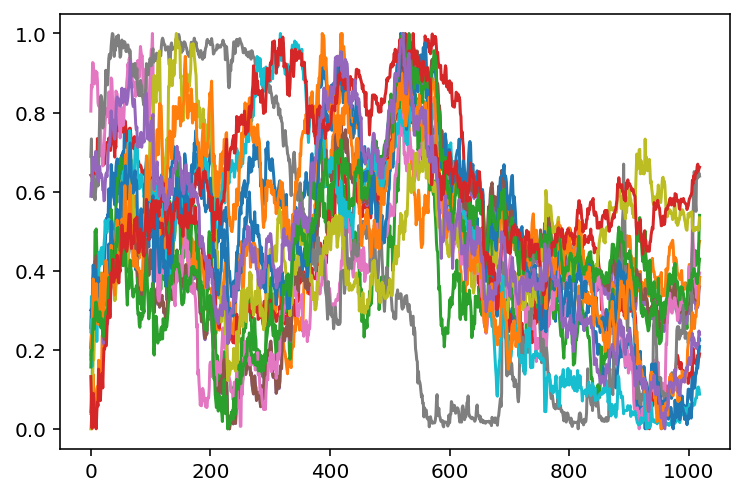

In [0]:
plt.plot(scaled)
plt.show()

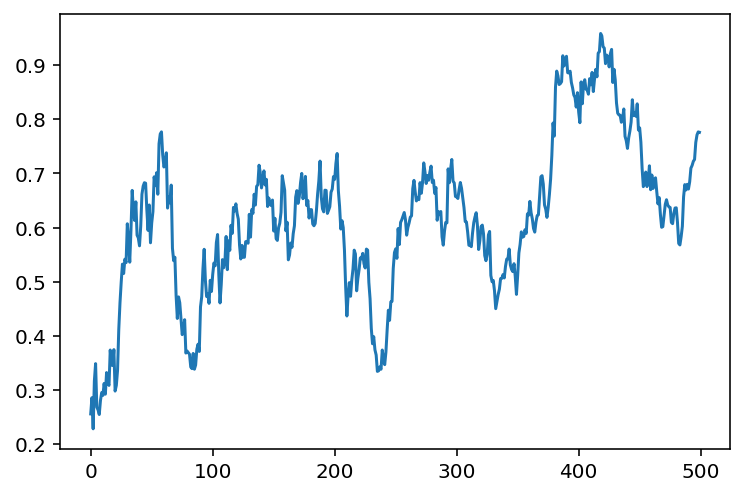

In [0]:
plt.plot(scaled[:,0][0:500])

In [0]:
# specify the number of lag hours
n_hours = 30
n_features = scaled.shape[1]
n_predict = 15
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predict)
print(reframed.shape)

(975, 675)


In [0]:
reframed.head()

var1(t-30)  var2(t-30)  var3(t-30)  ...  var13(t+14)  var14(t+14)  var15(t+14)
30    0.255932    0.038694    0.043929  ...     0.506708     0.439154     0.839394
31    0.285902    0.048891    0.086106  ...     0.505948     0.418830     0.832982
32    0.228419    0.000000    0.092978  ...     0.509514     0.373209     0.835065
33    0.316959    0.119473    0.209049  ...     0.485187     0.369314     0.833504
34    0.348768    0.137392    0.313253  ...     0.487888     0.404782     0.821411

[5 rows x 675 columns]

In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [0]:
# split into input and outputs
n_obs = n_hours * n_features

In [0]:
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 450) (500, 225)
(500, 30, 15) (500, 225) (475, 30, 15) (475, 225)


In [0]:
train_X[0]

array([[0.25593185, 0.0386939 , 0.0439291 , 0.64156723, 0.18777752,
        0.20543861, 0.8036547 , 0.68912506, 0.        , 0.24512935,
        0.30025148, 0.1762433 , 0.15635943, 0.1321969 , 0.5885236 ],
       [0.28590202, 0.04889107, 0.0861063 , 0.63893175, 0.22134686,
        0.23911333, 0.86938477, 0.7333145 , 0.01928616, 0.3348639 ,
        0.30319977, 0.23539543, 0.19794154, 0.07479477, 0.62116647],
       [0.2284193 , 0.        , 0.09297752, 0.6373286 , 0.23259163,
        0.25079298, 0.8626237 , 0.5869827 , 0.05771112, 0.15758896,
        0.28015852, 0.21541405, 0.19821048, 0.00151777, 0.6084964 ],
       [0.3169589 , 0.1194725 , 0.20904922, 0.64053583, 0.31331444,
        0.33052063, 0.9264169 , 0.6046219 , 0.1270628 , 0.27230763,
        0.37307405, 0.31450033, 0.24432397, 0.08500123, 0.66509414],
       [0.34876776, 0.13739157, 0.3132534 , 0.6545415 , 0.36399508,
        0.3819189 , 0.9247265 , 0.640358  , 0.17844152, 0.28787732,
        0.4143176 , 0.37907553, 0.27793026, 

In [0]:
train_y[0]

array([0.6069503 , 0.38614464, 0.40973663, 0.7353339 , 0.35148287,
       0.36681175, 0.8520665 , 0.9360504 , 0.30978966, 0.5302913 ,
       0.46760988, 0.38757133, 0.3826518 , 0.3251357 , 0.72002053,
       0.5770712 , 0.36773443, 0.37049484, 0.7298155 , 0.3210435 ,
       0.33569098, 0.81666756, 0.9474716 , 0.30751848, 0.52515244,
       0.4306388 , 0.34397173, 0.3727312 , 0.31184864, 0.7148278 ],
      dtype=float32)

In [0]:
values[:,0][0:n_hours+n_predict]

array([0.25593185, 0.28590202, 0.2284193 , 0.3169589 , 0.34876776,
       0.26837587, 0.26339102, 0.25486803, 0.28088236, 0.2952509 ,
       0.29021263, 0.31223917, 0.2923708 , 0.33226538, 0.31369066,
       0.30861568, 0.37390852, 0.3461938 , 0.3454585 , 0.3746519 ,
       0.2981348 , 0.30861568, 0.33628893, 0.41171074, 0.46119356,
       0.49924374, 0.5324764 , 0.51516104, 0.5415735 , 0.5352416 ,
       0.6069503 , 0.5770712 ], dtype=float32)

Train on 500 samples, validate on 475 samples
Epoch 1/100
 - 1s - loss: 0.3465 - val_loss: 0.1665
Epoch 2/100
 - 0s - loss: 0.2659 - val_loss: 0.1250
Epoch 3/100
 - 0s - loss: 0.1911 - val_loss: 0.0894
Epoch 4/100
 - 0s - loss: 0.1267 - val_loss: 0.0692
Epoch 5/100
 - 0s - loss: 0.0850 - val_loss: 0.0515
Epoch 6/100
 - 0s - loss: 0.0588 - val_loss: 0.0468
Epoch 7/100
 - 0s - loss: 0.0447 - val_loss: 0.0413
Epoch 8/100
 - 0s - loss: 0.0381 - val_loss: 0.0412
Epoch 9/100
 - 0s - loss: 0.0354 - val_loss: 0.0398
Epoch 10/100
 - 0s - loss: 0.0336 - val_loss: 0.0389
Epoch 11/100
 - 0s - loss: 0.0320 - val_loss: 0.0375
Epoch 12/100
 - 0s - loss: 0.0307 - val_loss: 0.0372
Epoch 13/100
 - 0s - loss: 0.0295 - val_loss: 0.0366
Epoch 14/100
 - 0s - loss: 0.0282 - val_loss: 0.0367
Epoch 15/100
 - 0s - loss: 0.0267 - val_loss: 0.0352
Epoch 16/100
 - 0s - loss: 0.0254 - val_loss: 0.0352
Epoch 17/100
 - 0s - loss: 0.0240 - val_loss: 0.0335
Epoch 18/100
 - 0s - loss: 0.0226 - val_loss: 0.0334
Epoch 19/

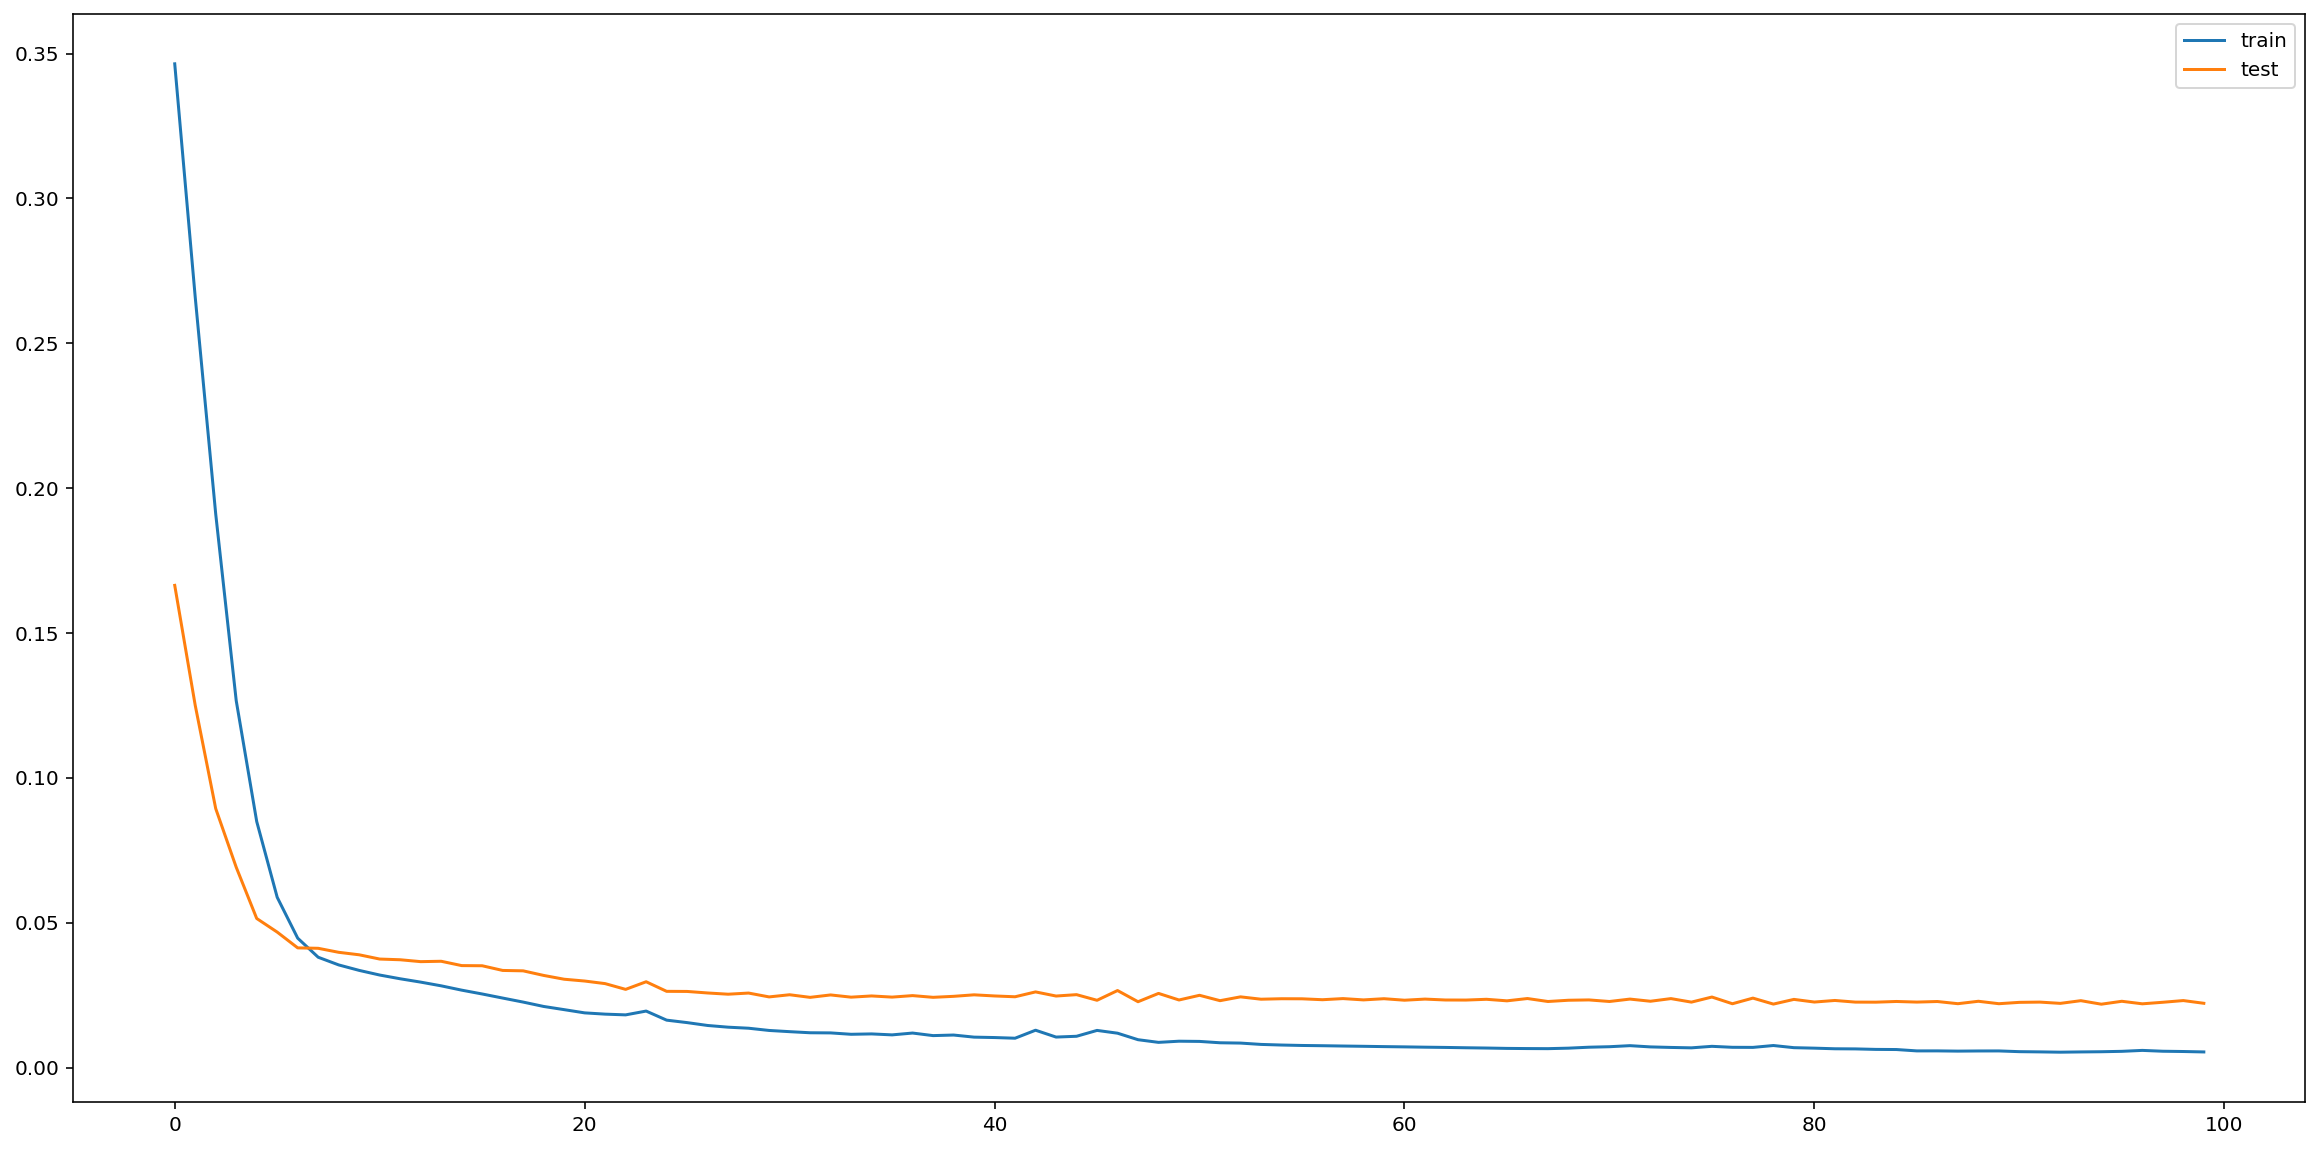

In [0]:
# design network
model = Sequential()
model.add(SimpleRNN(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='relu'))
model.add(SimpleRNN(128, return_sequences=False, activation='relu'))
model.add(Dense(train_y.shape[1], activation='linear'))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
fig, ax = plt.subplots(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
def predict(start_arr, dist):
    res = np.array(start_arr)[:,0:n_features]
    
    for i in range(dist):
        pred = model.predict(np.array([res[-n_hours:]])).reshape(n_predict,n_features)
        res = np.concatenate((res, pred))
        if len(res) > dist + len(start_arr):
            break
    
    return res

In [0]:
res = []
i = 0
n = 1

while len(res) < len(test_y):
  temp_res = test_X[i]
  for j in range(n):
    temp_res = np.concatenate((temp_res, model.predict(np.array([temp_res[-n_hours:]]))))
    res.append(temp_res[-1])
  i = i + n

y_pred = np.array(res)[:len(test_y)]
y_hat = scaler.inverse_transform(test_y)
y_pred = scaler.inverse_transform(y_pred)

ValueError: ignored

In [0]:
res = []
i = 0
n = 1

while i < len(test_y):
  temp_res = test_X[i]
  for j in range(n):
    temp_res = np.concatenate((temp_res, model.predict(np.array([temp_res[-n_hours:]])).reshape(n_predict,n_features)))
    res.append(temp_res[-n_predict:])
  i = i + n*n_predict

y_pred = np.array(res)
y_pred = np.array(y_pred.reshape(len(y_pred)*n_predict, n_features))[:len(test_y)]
y_hat = scaler.inverse_transform(test_y[:, 0:n_features])
y_pred = scaler.inverse_transform(y_pred)

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(y_hat[:, i], color='green')
    plt.plot(y_pred[:, i], color='red')
    plt.show()

In [0]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=53555ceec0d024fb83c3acd2d8be082a6357f863b1926ce6c9903a9e5adf2e02
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
import ml_metrics as metrics

In [0]:
metrics.rmse(y_hat[:, -2], y_pred[:, -2])

0.00054149696

In [0]:
metrics.mae(y_hat[:, -2], y_pred[:, -2])

0.00043159362

In [0]:
metrics.rmse(y_hat, y_pred)

0.012421891

In [0]:
metrics.mae(y_hat, y_pred)

0.007212146

In [0]:
from statsmodels.tsa.stattools import acf, pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


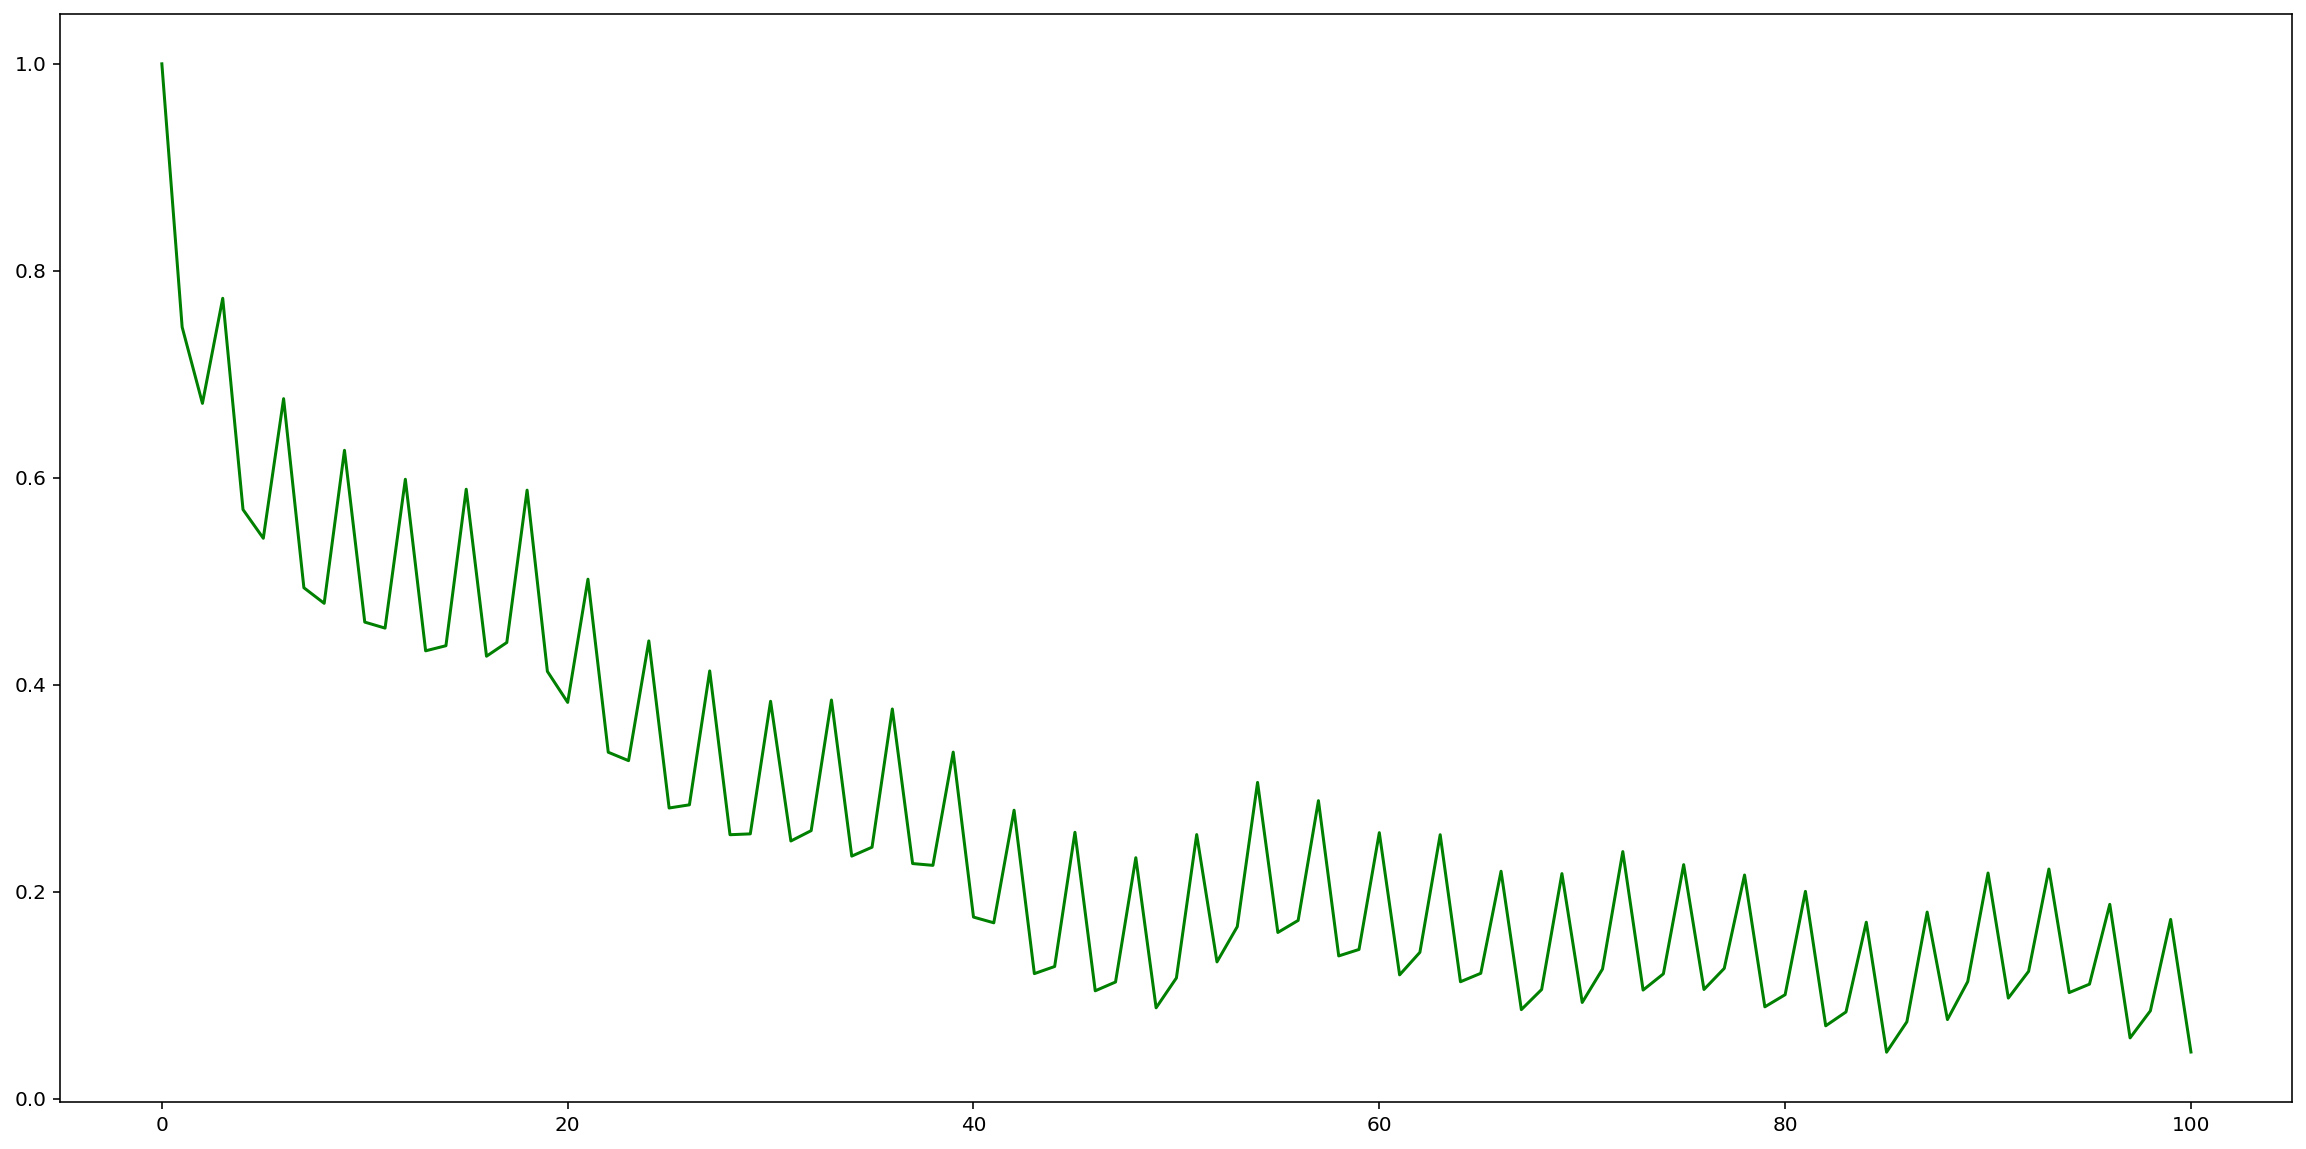

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


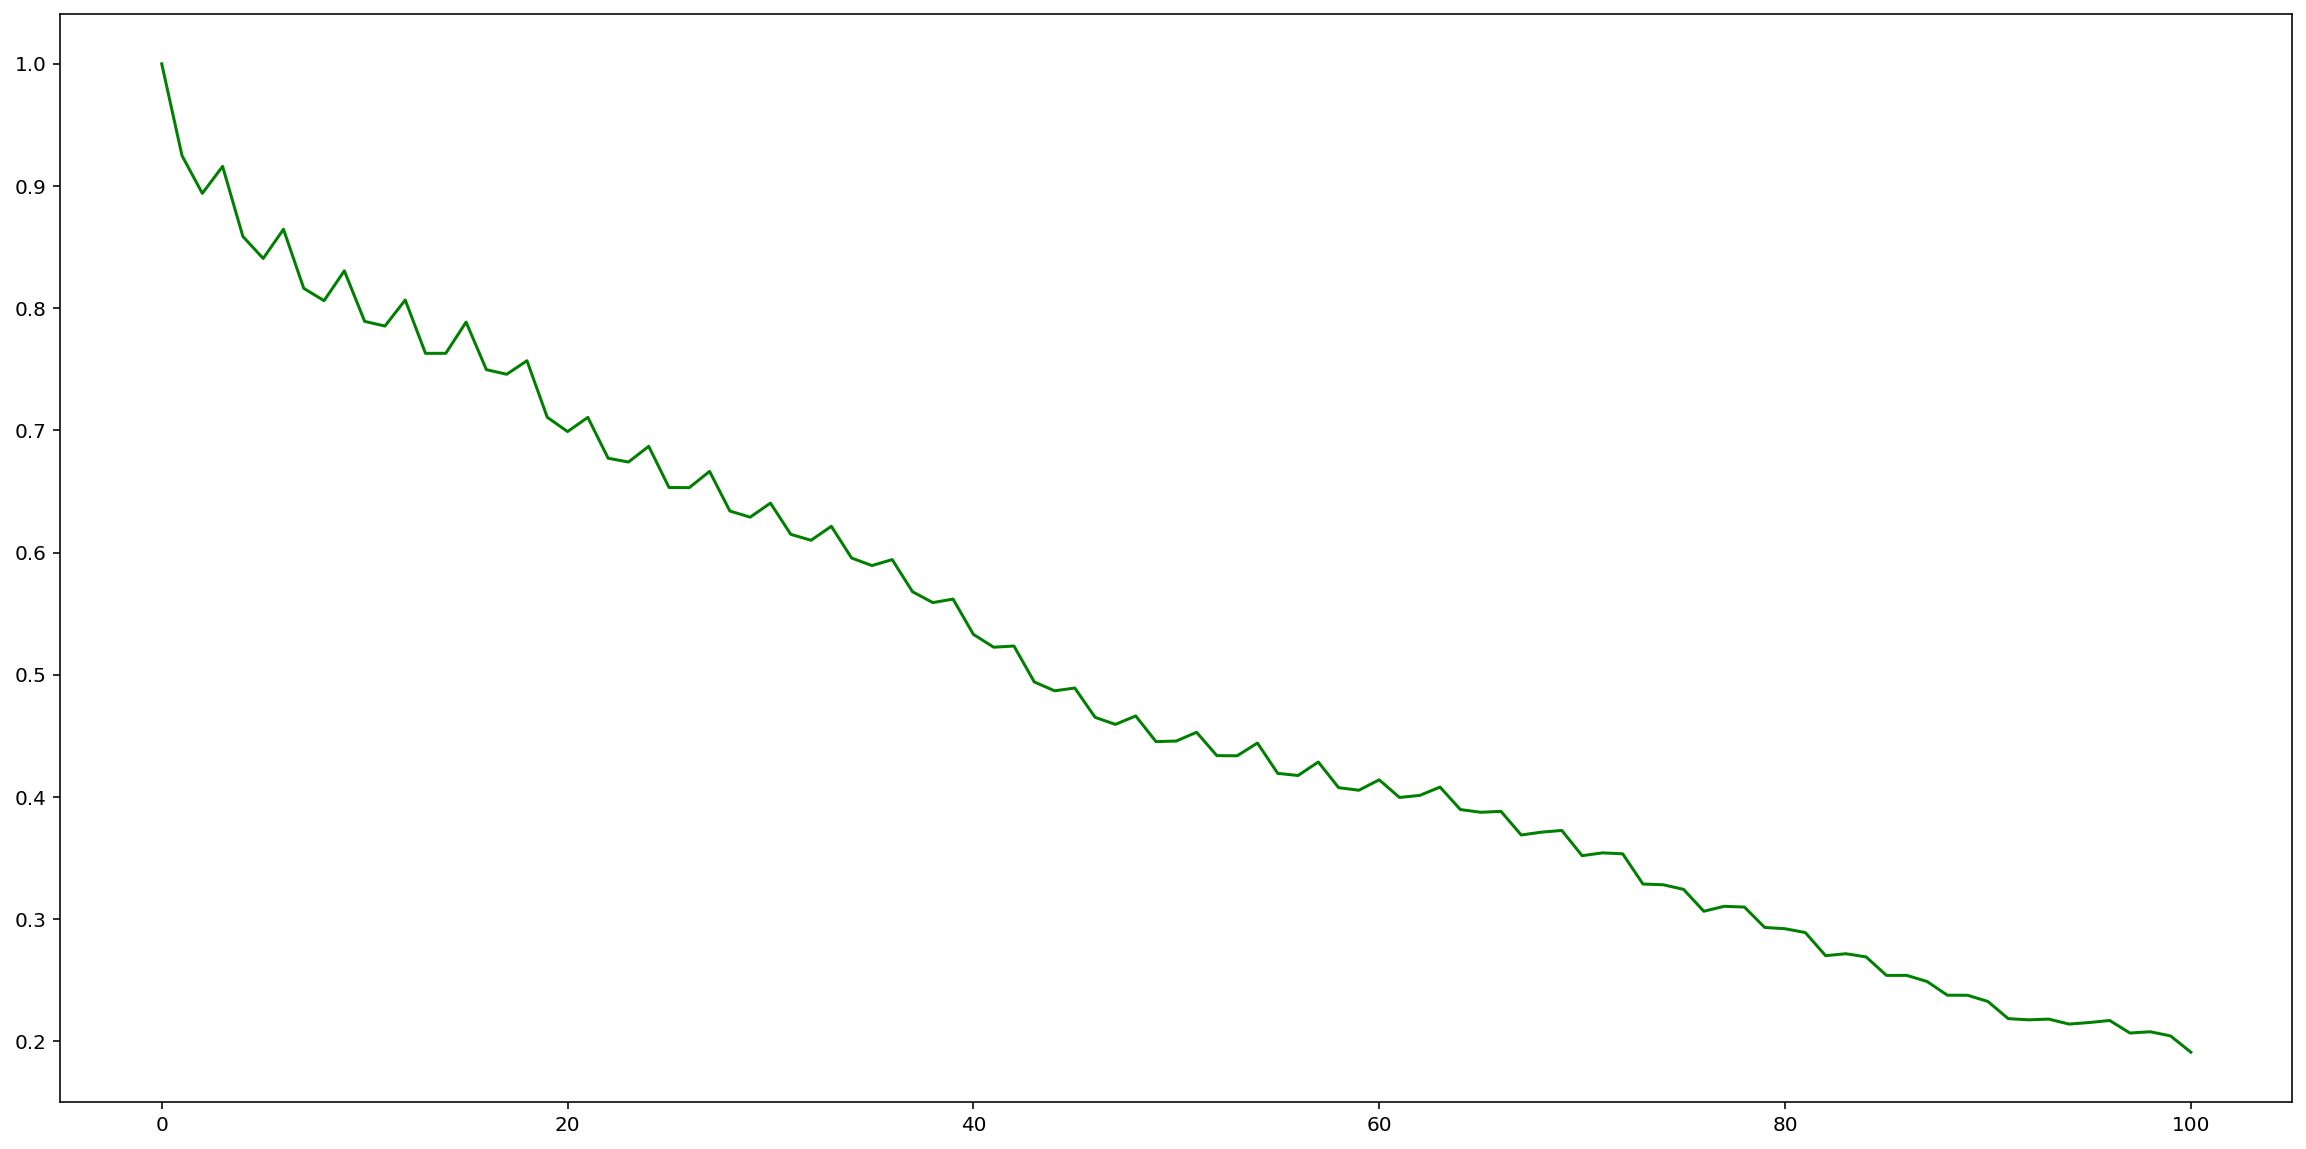

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


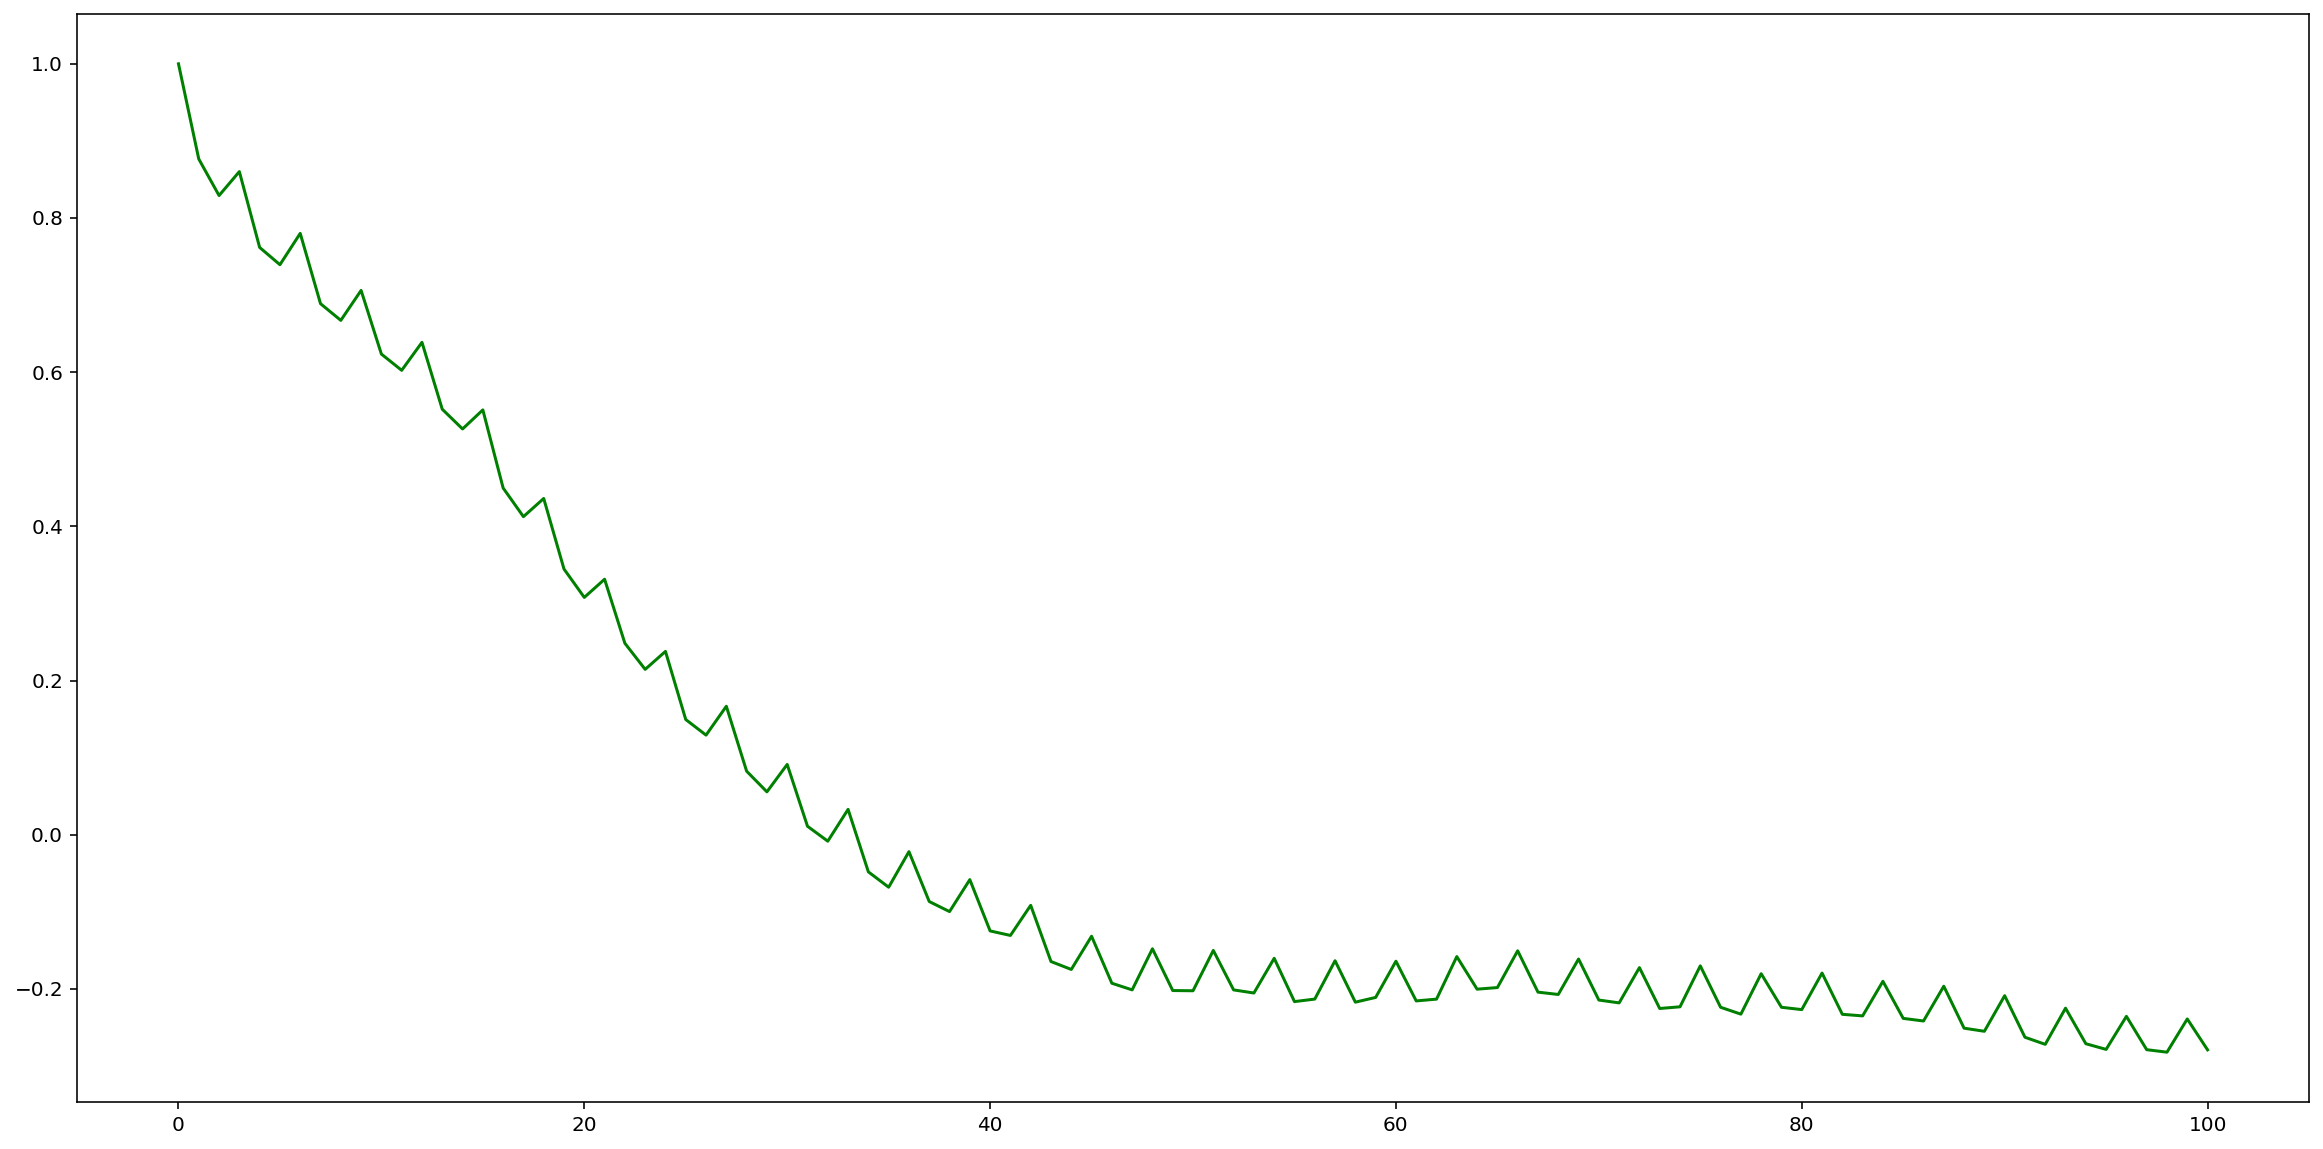

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


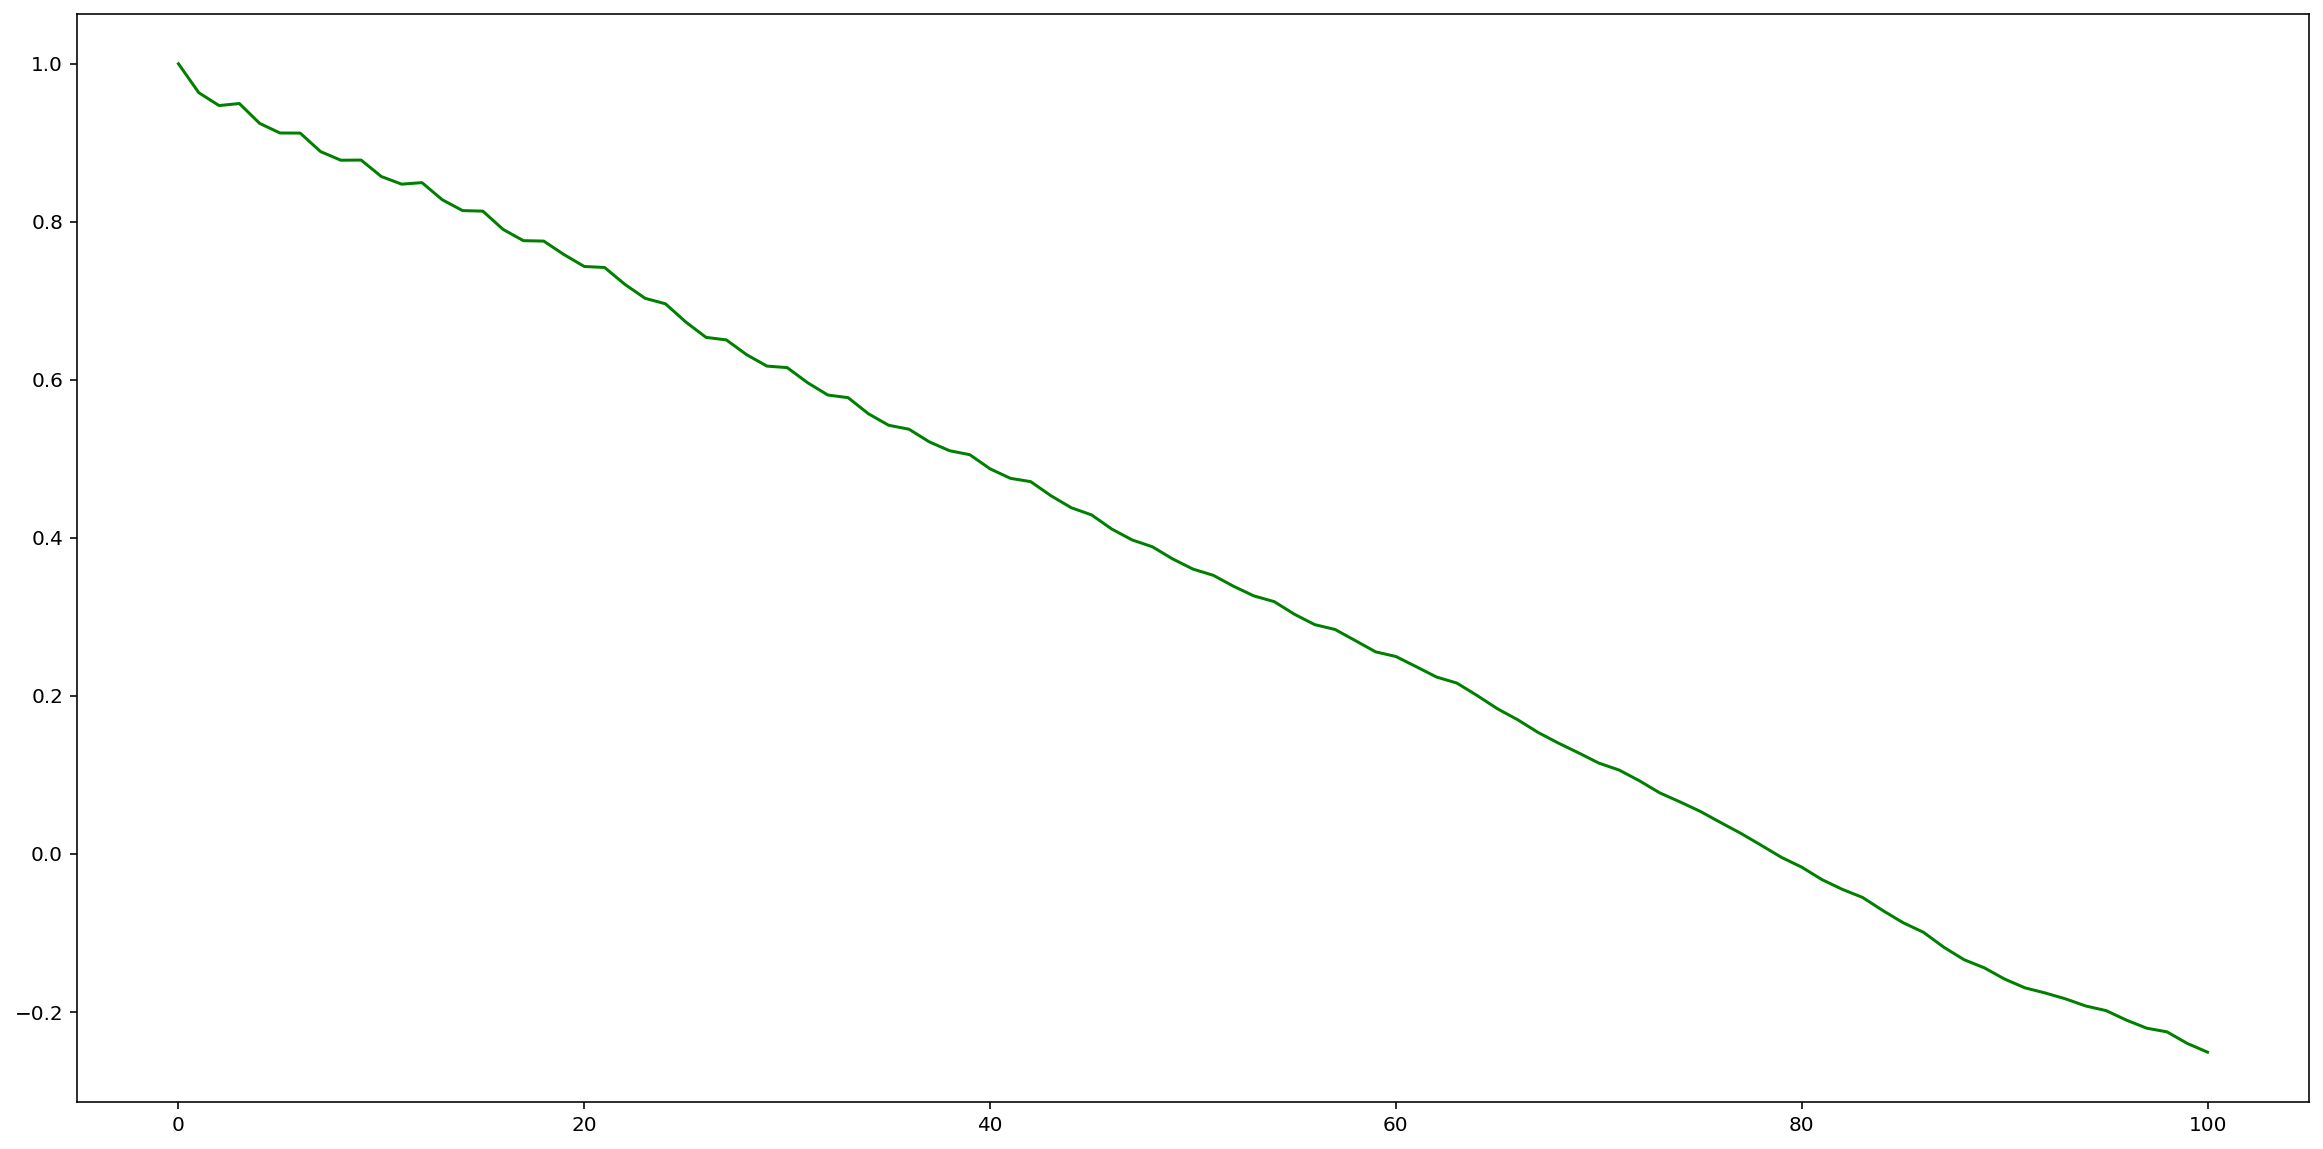

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


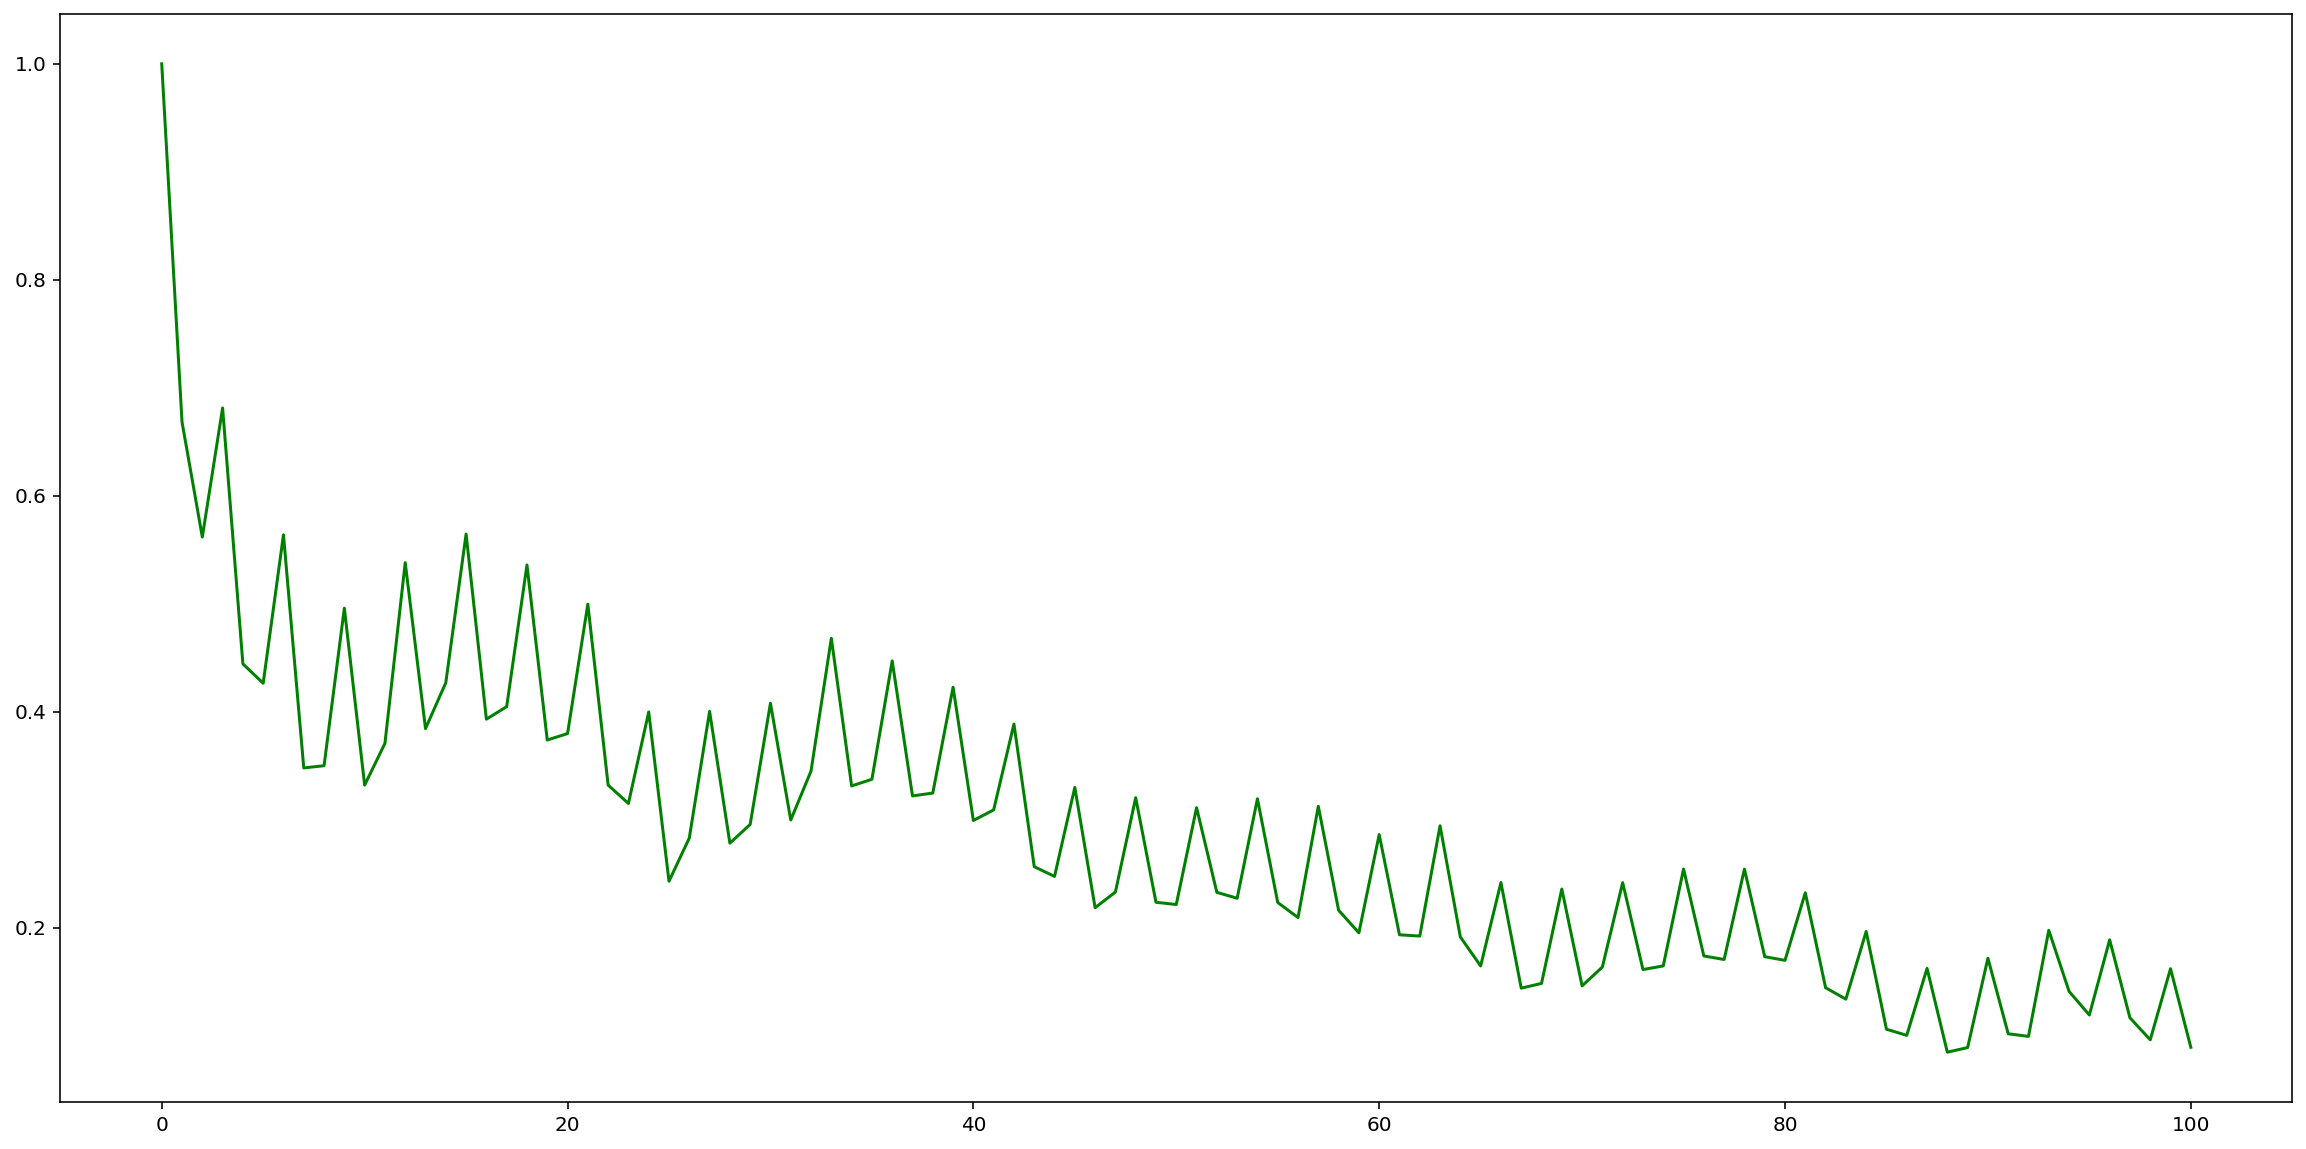

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


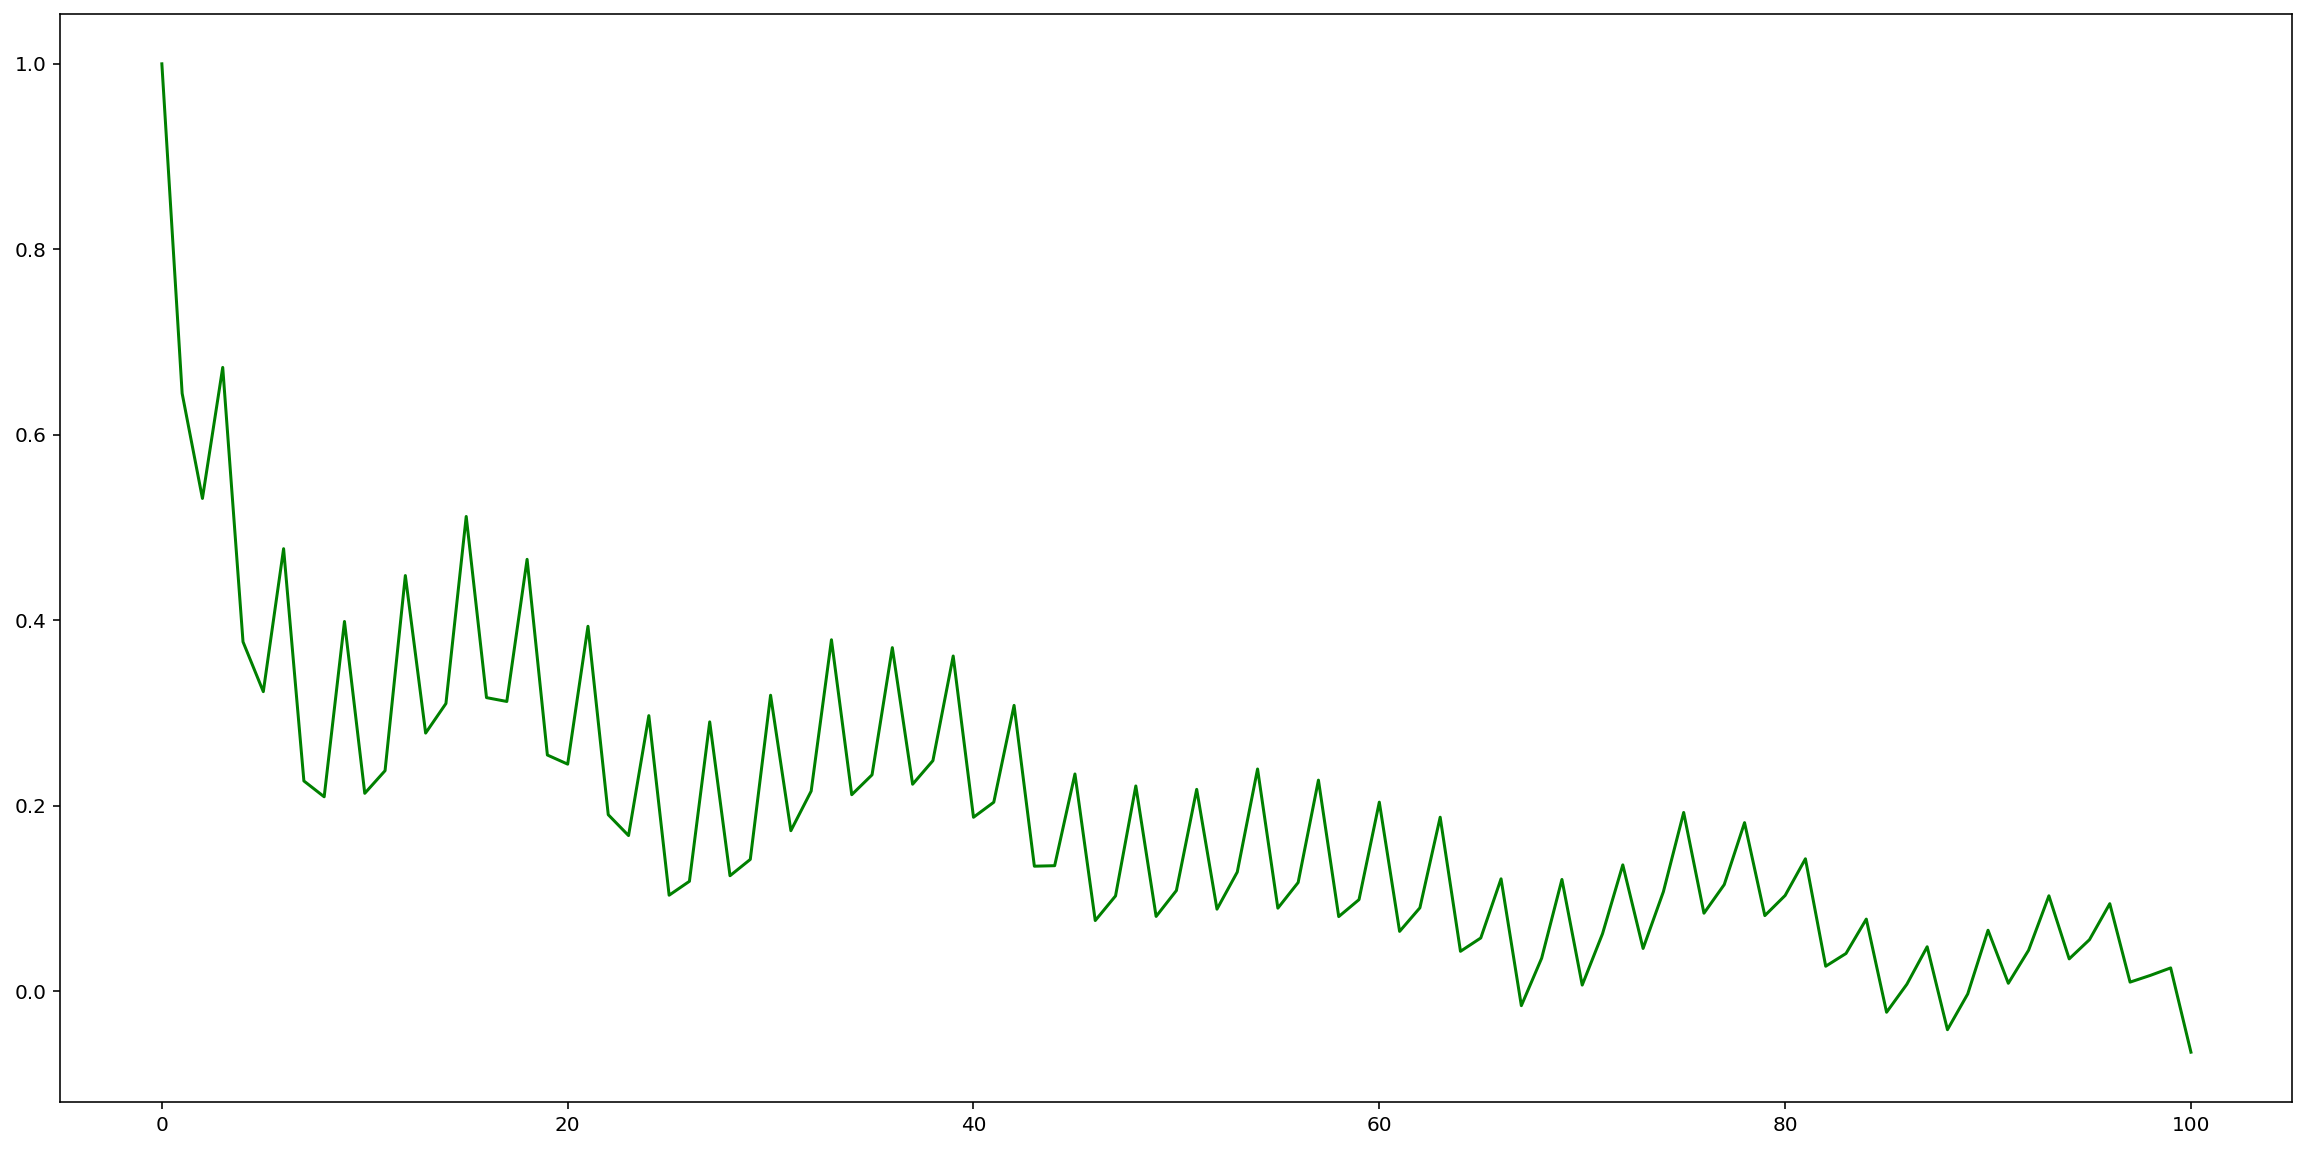

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


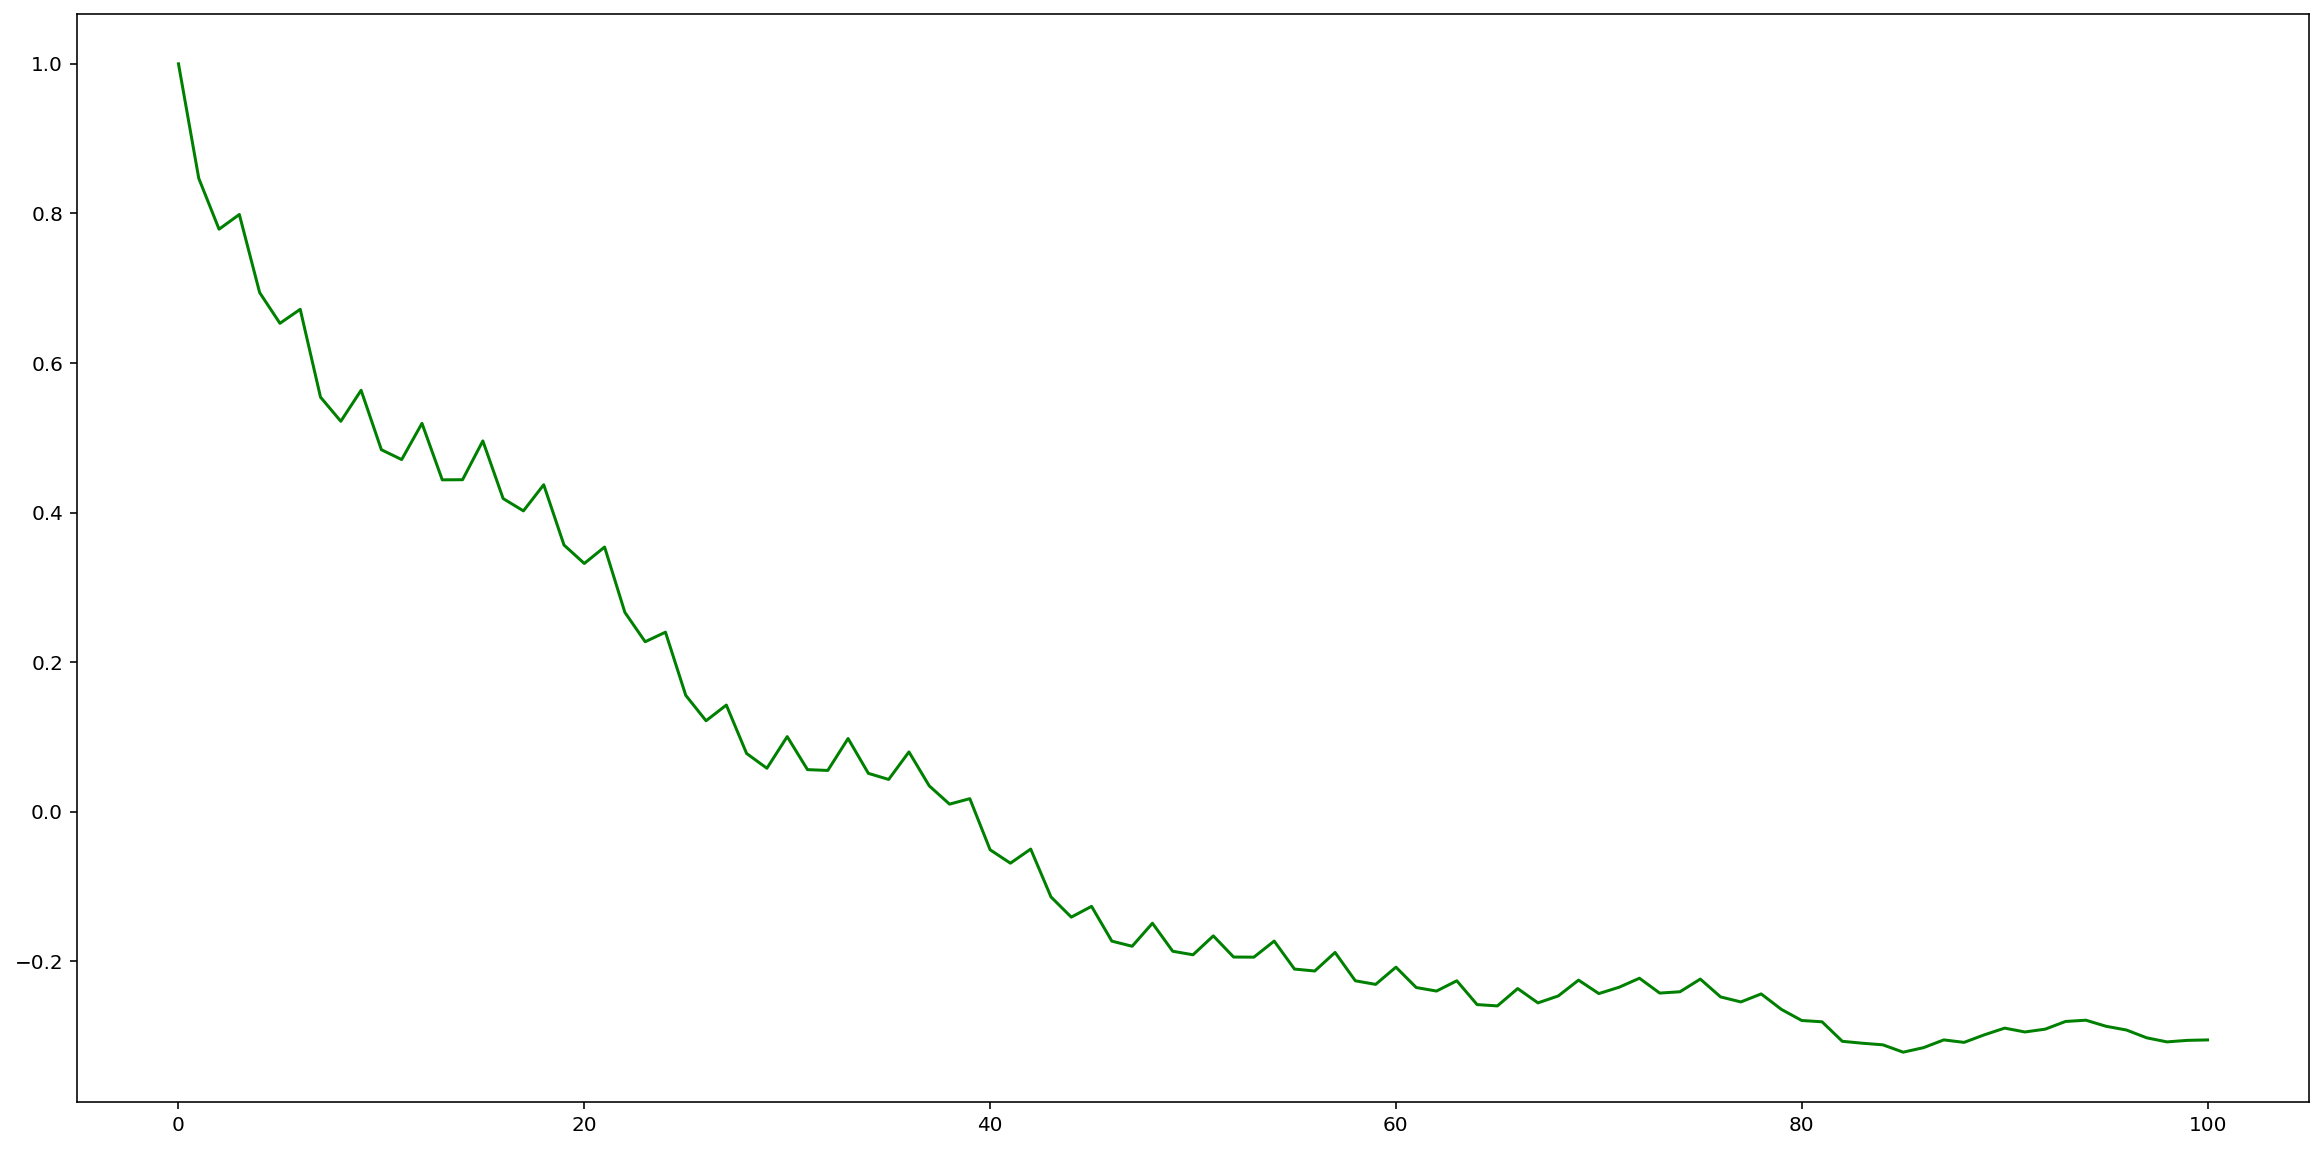

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


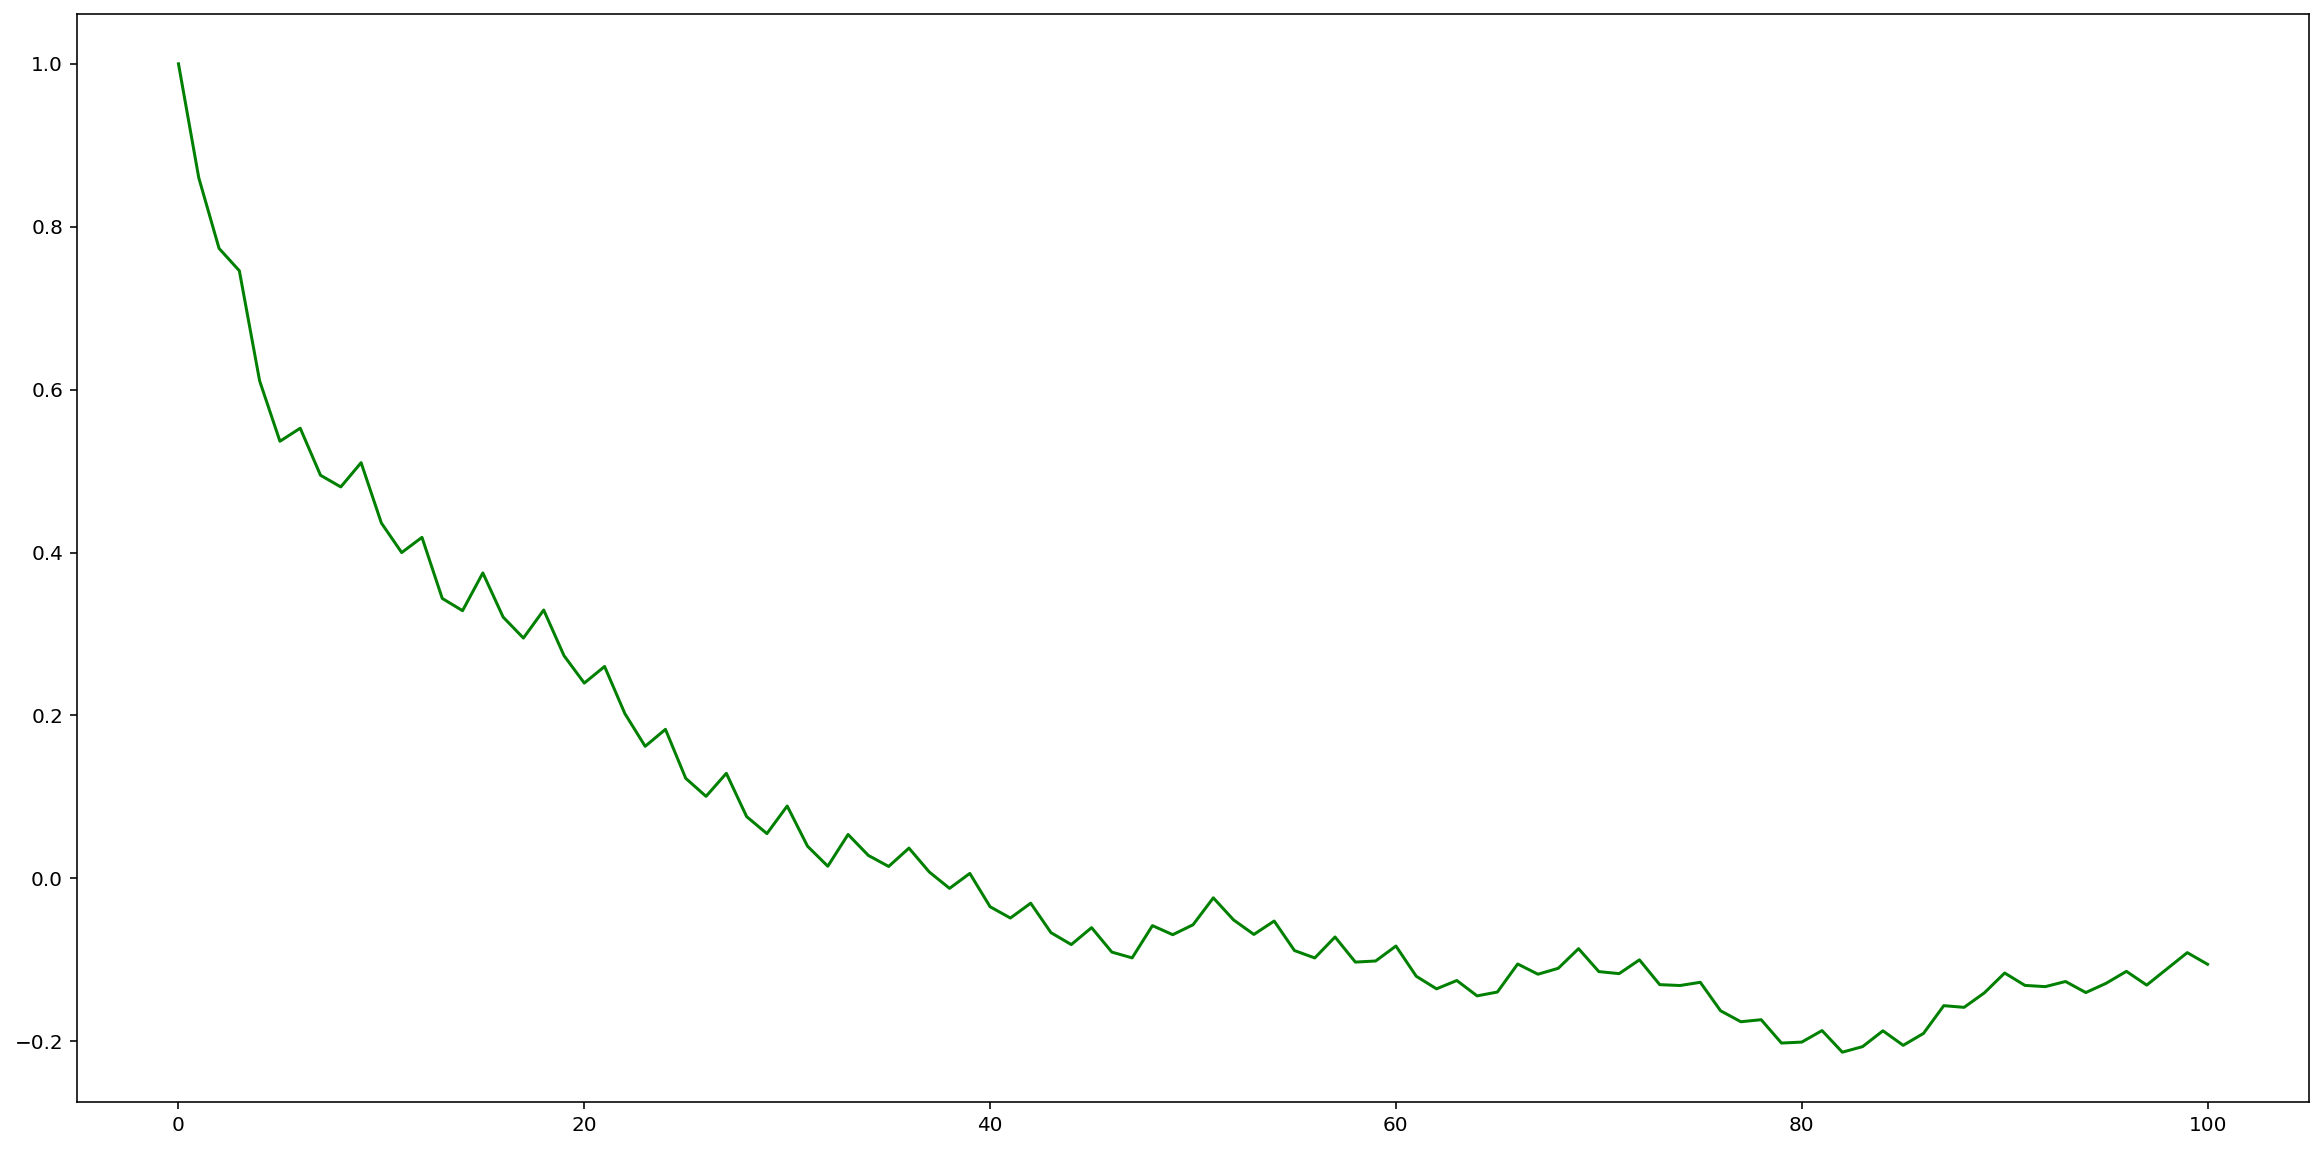

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


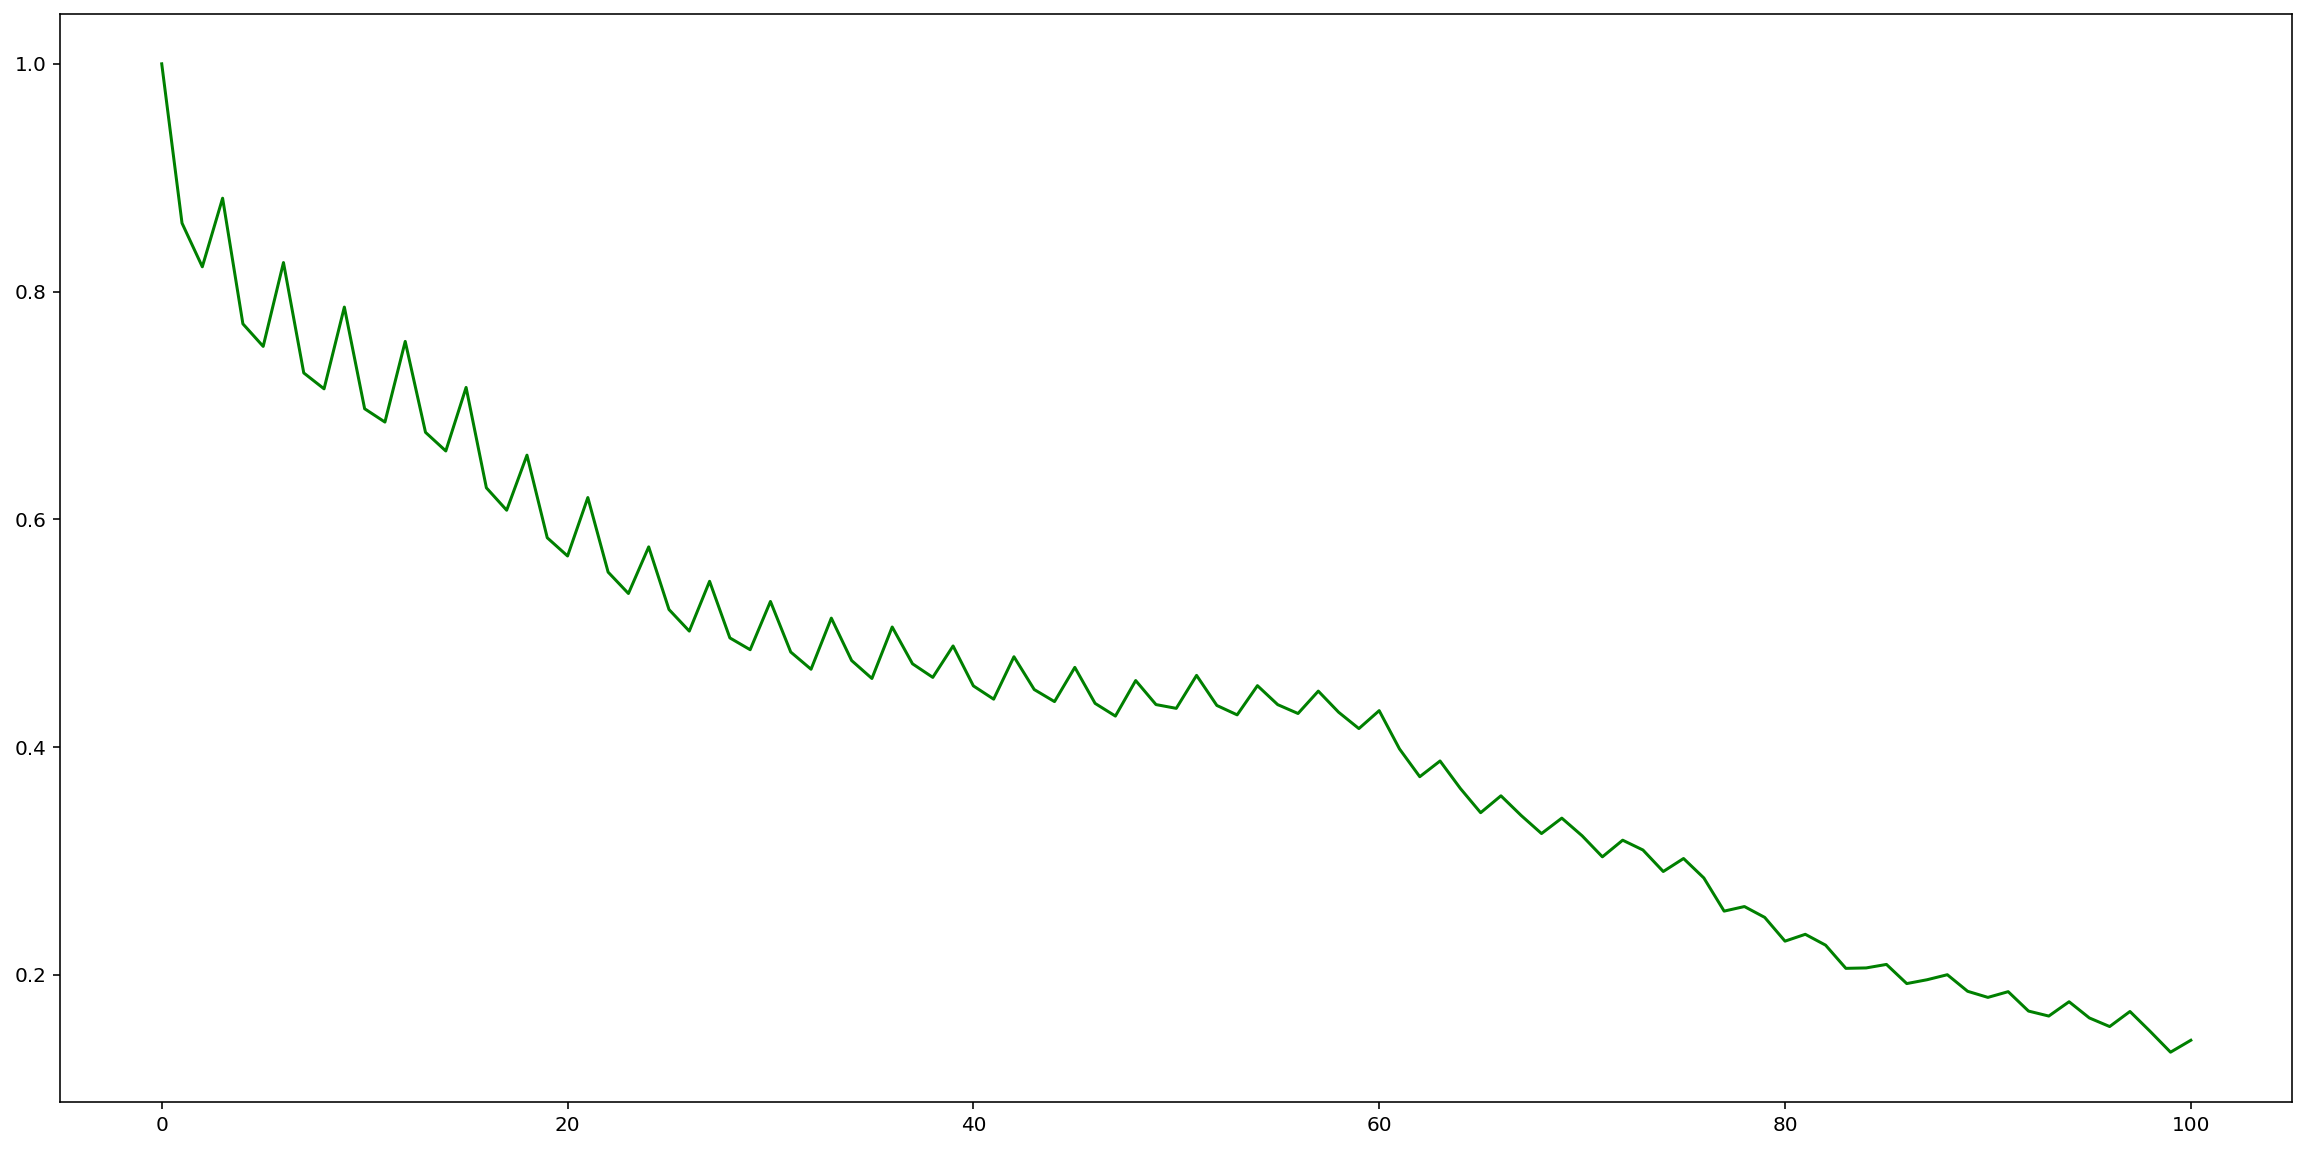

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


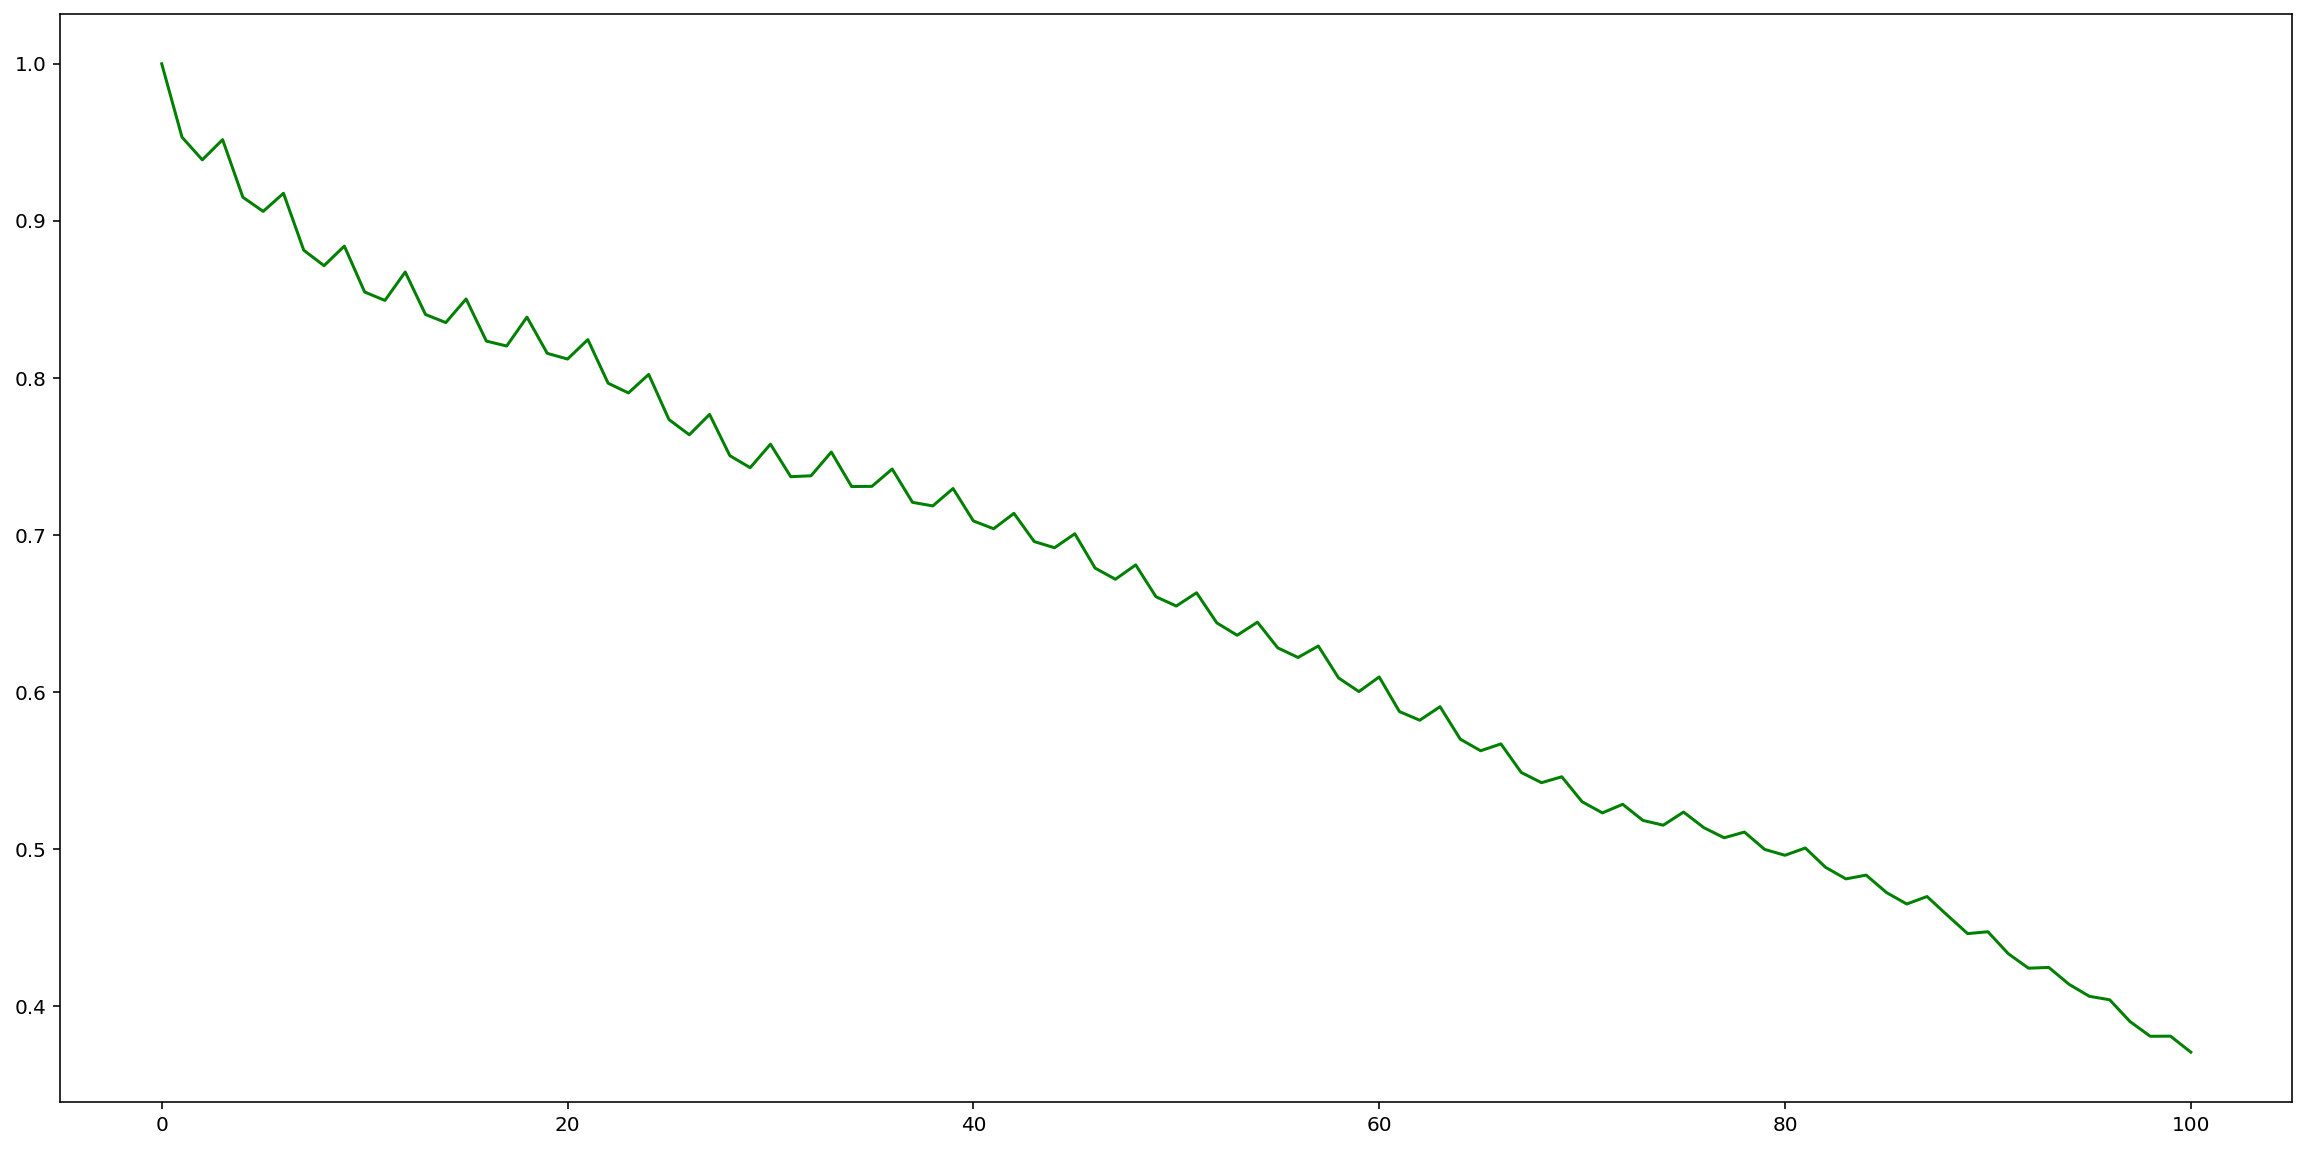

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


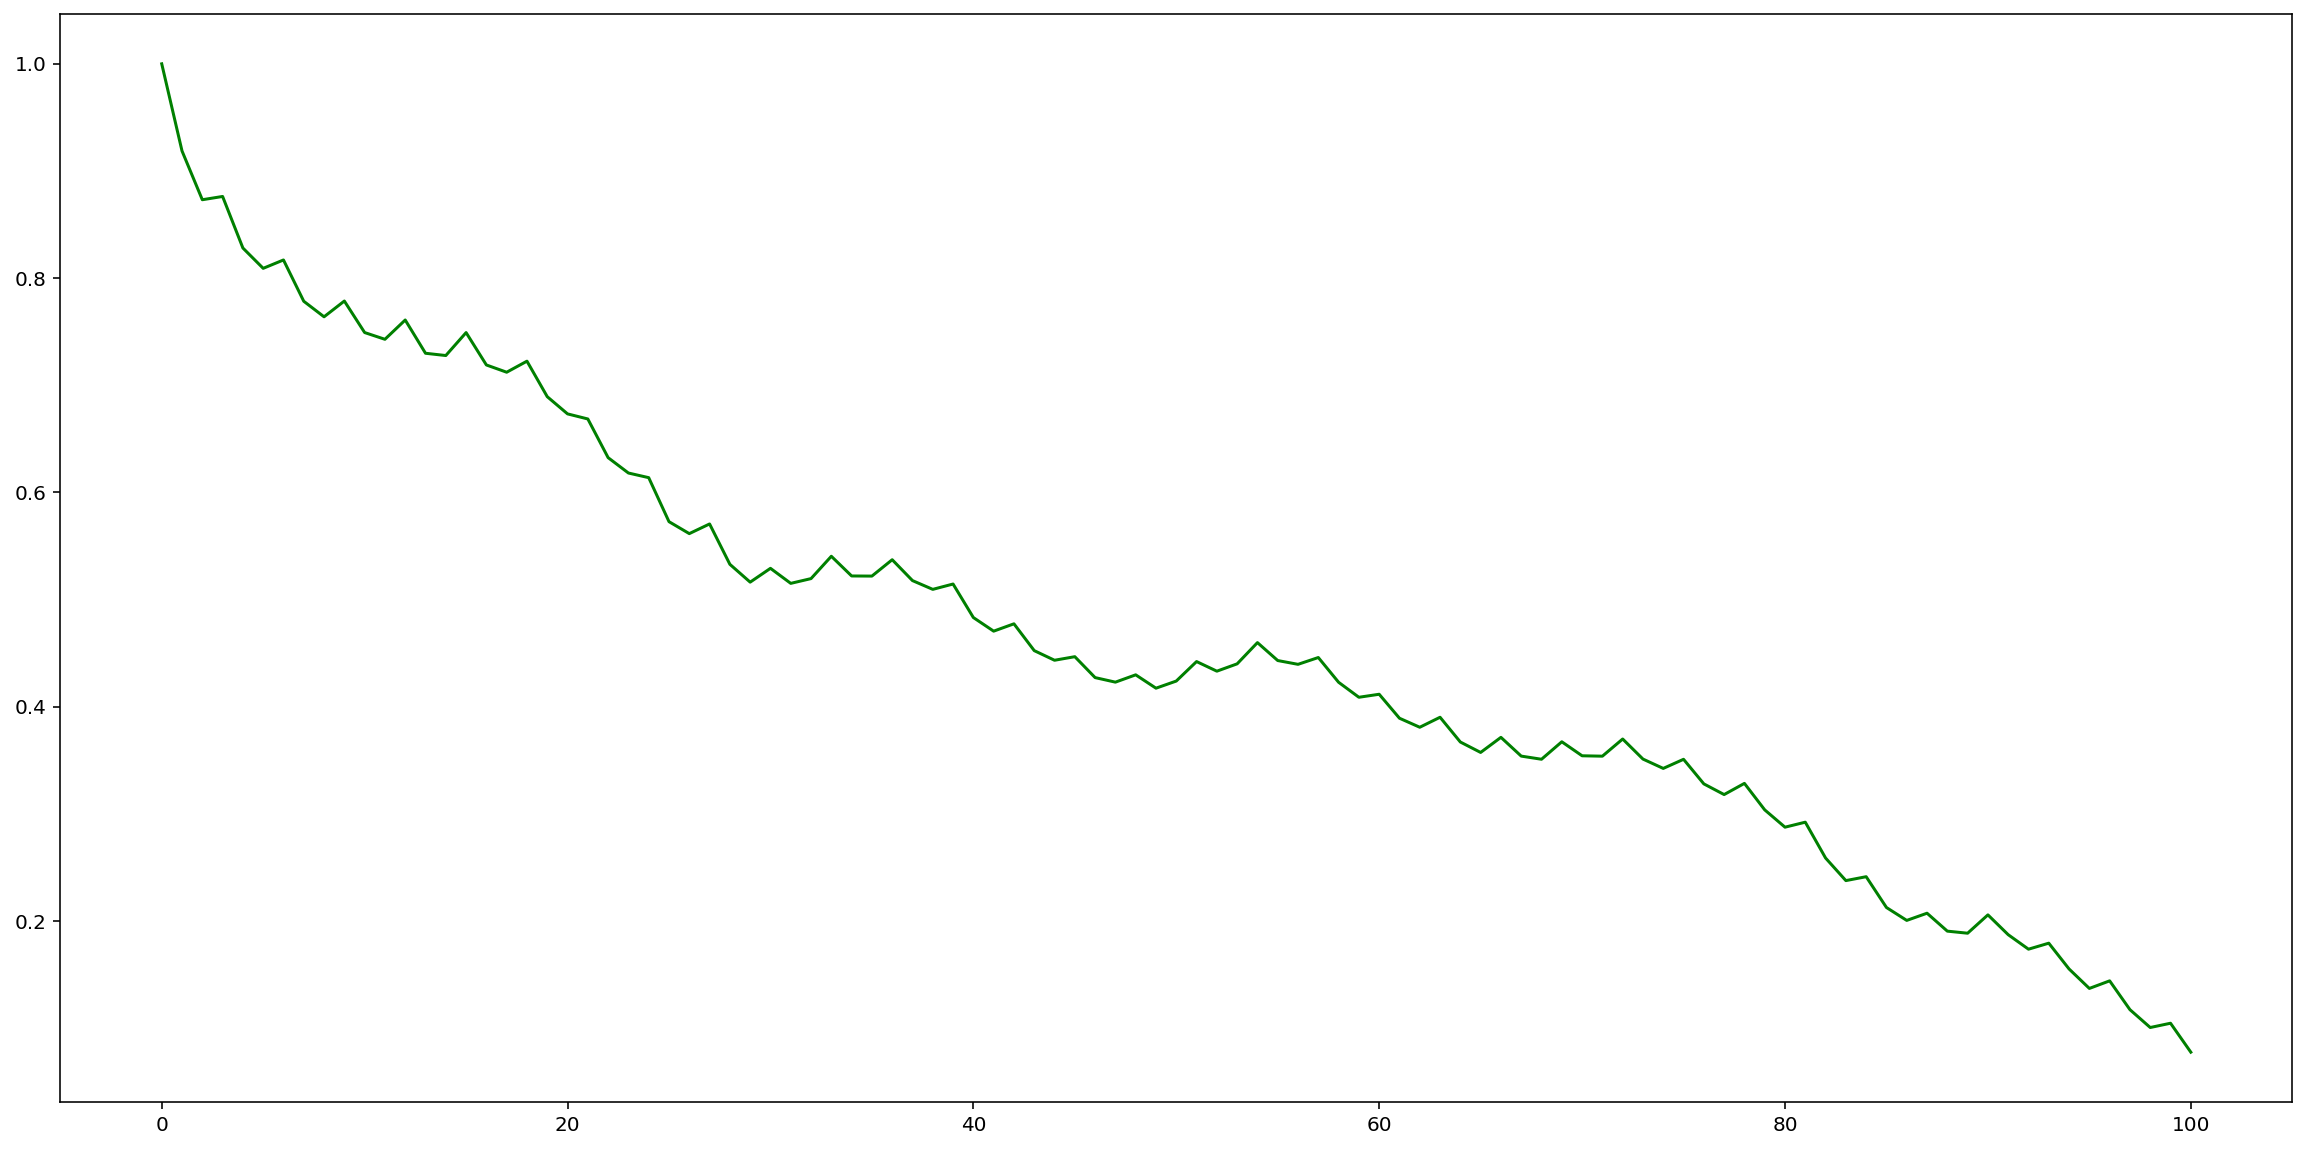

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


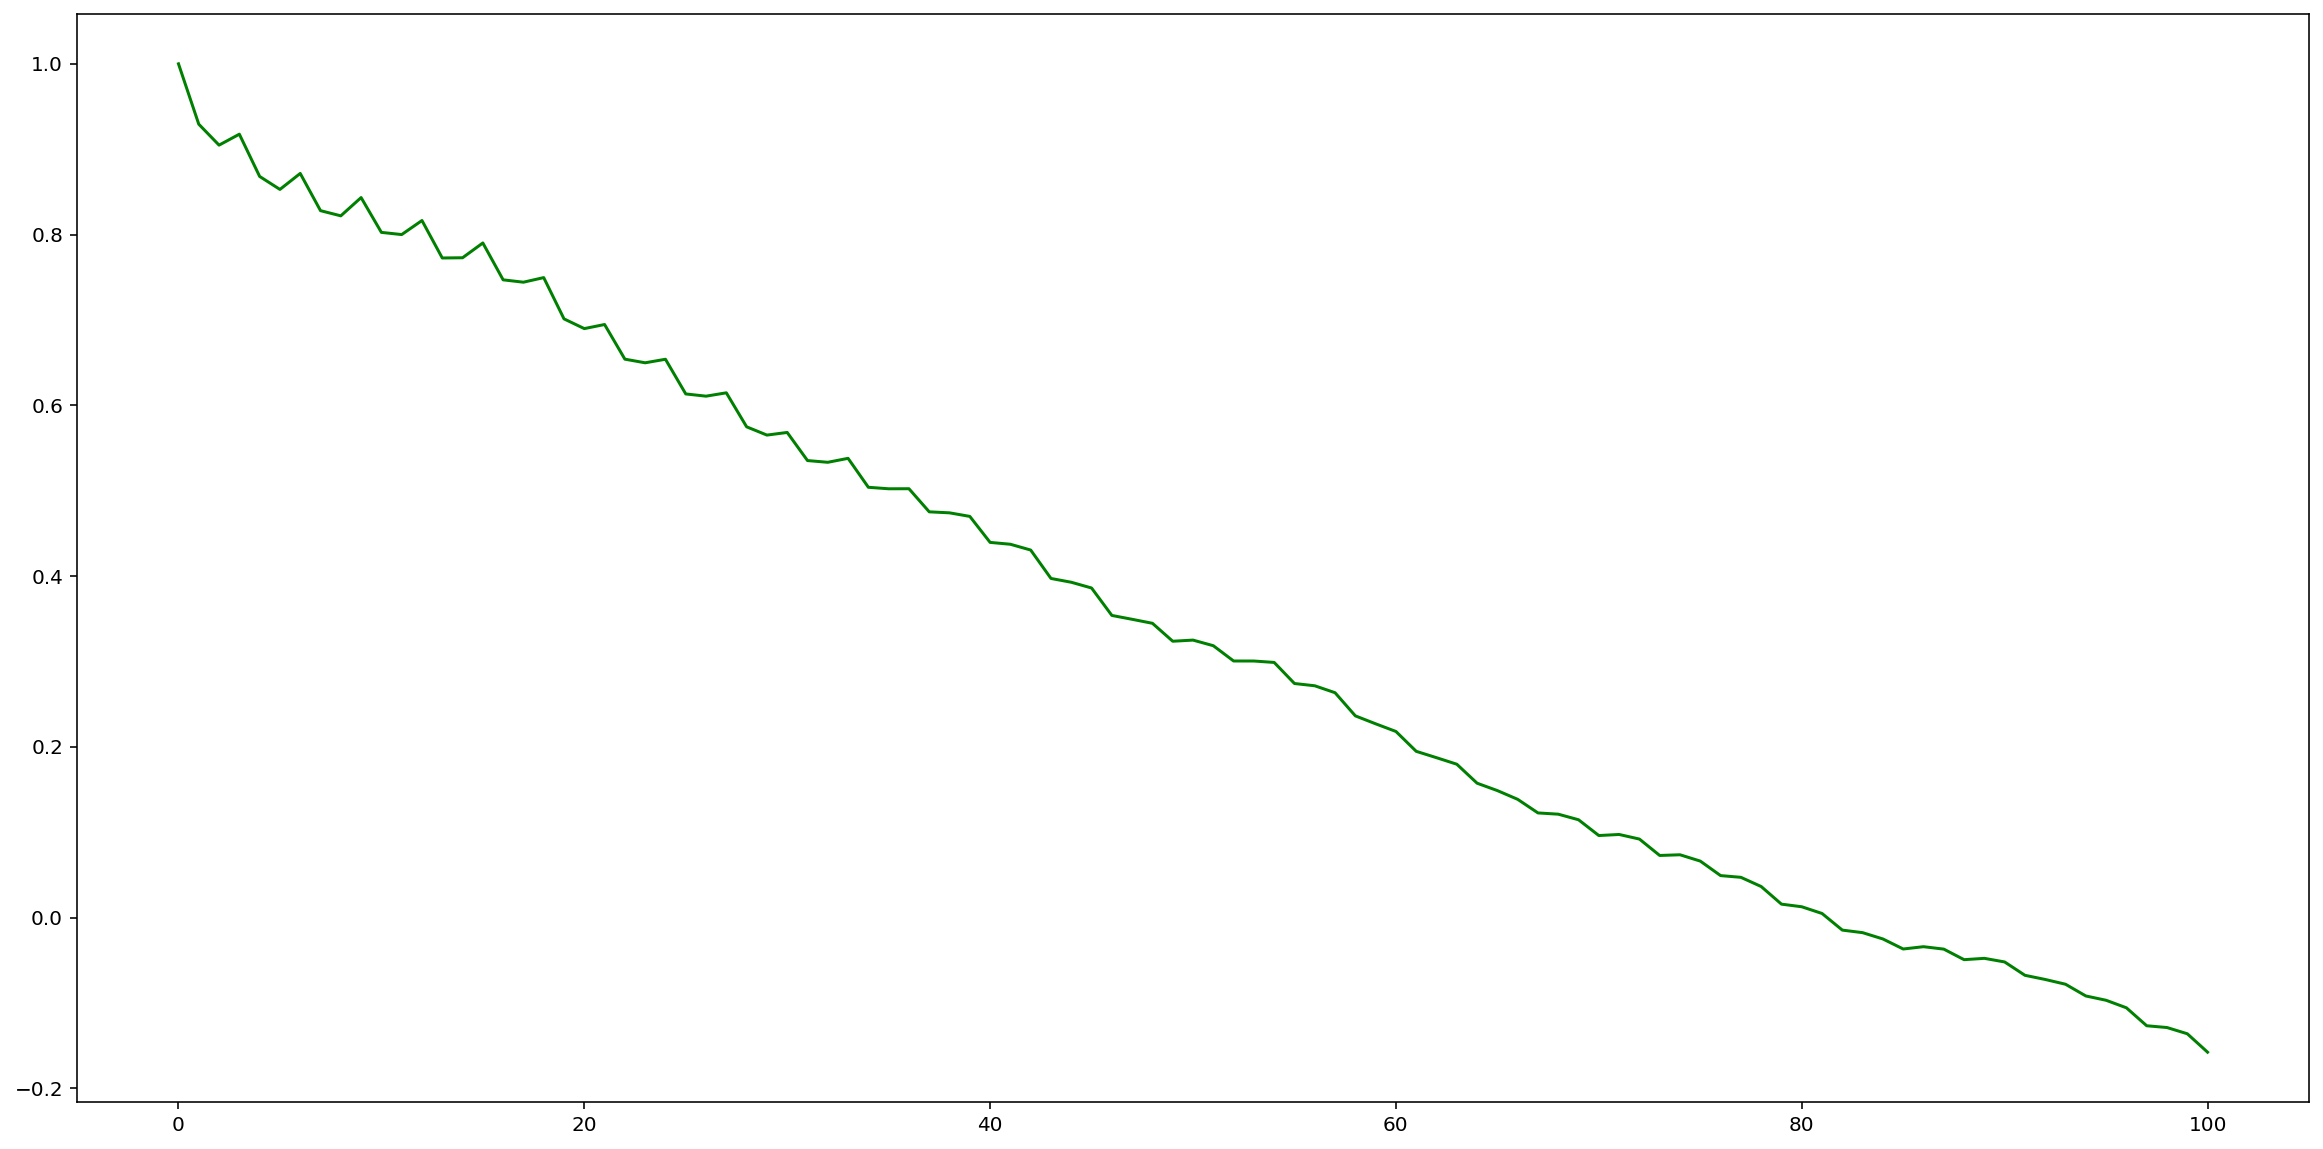

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


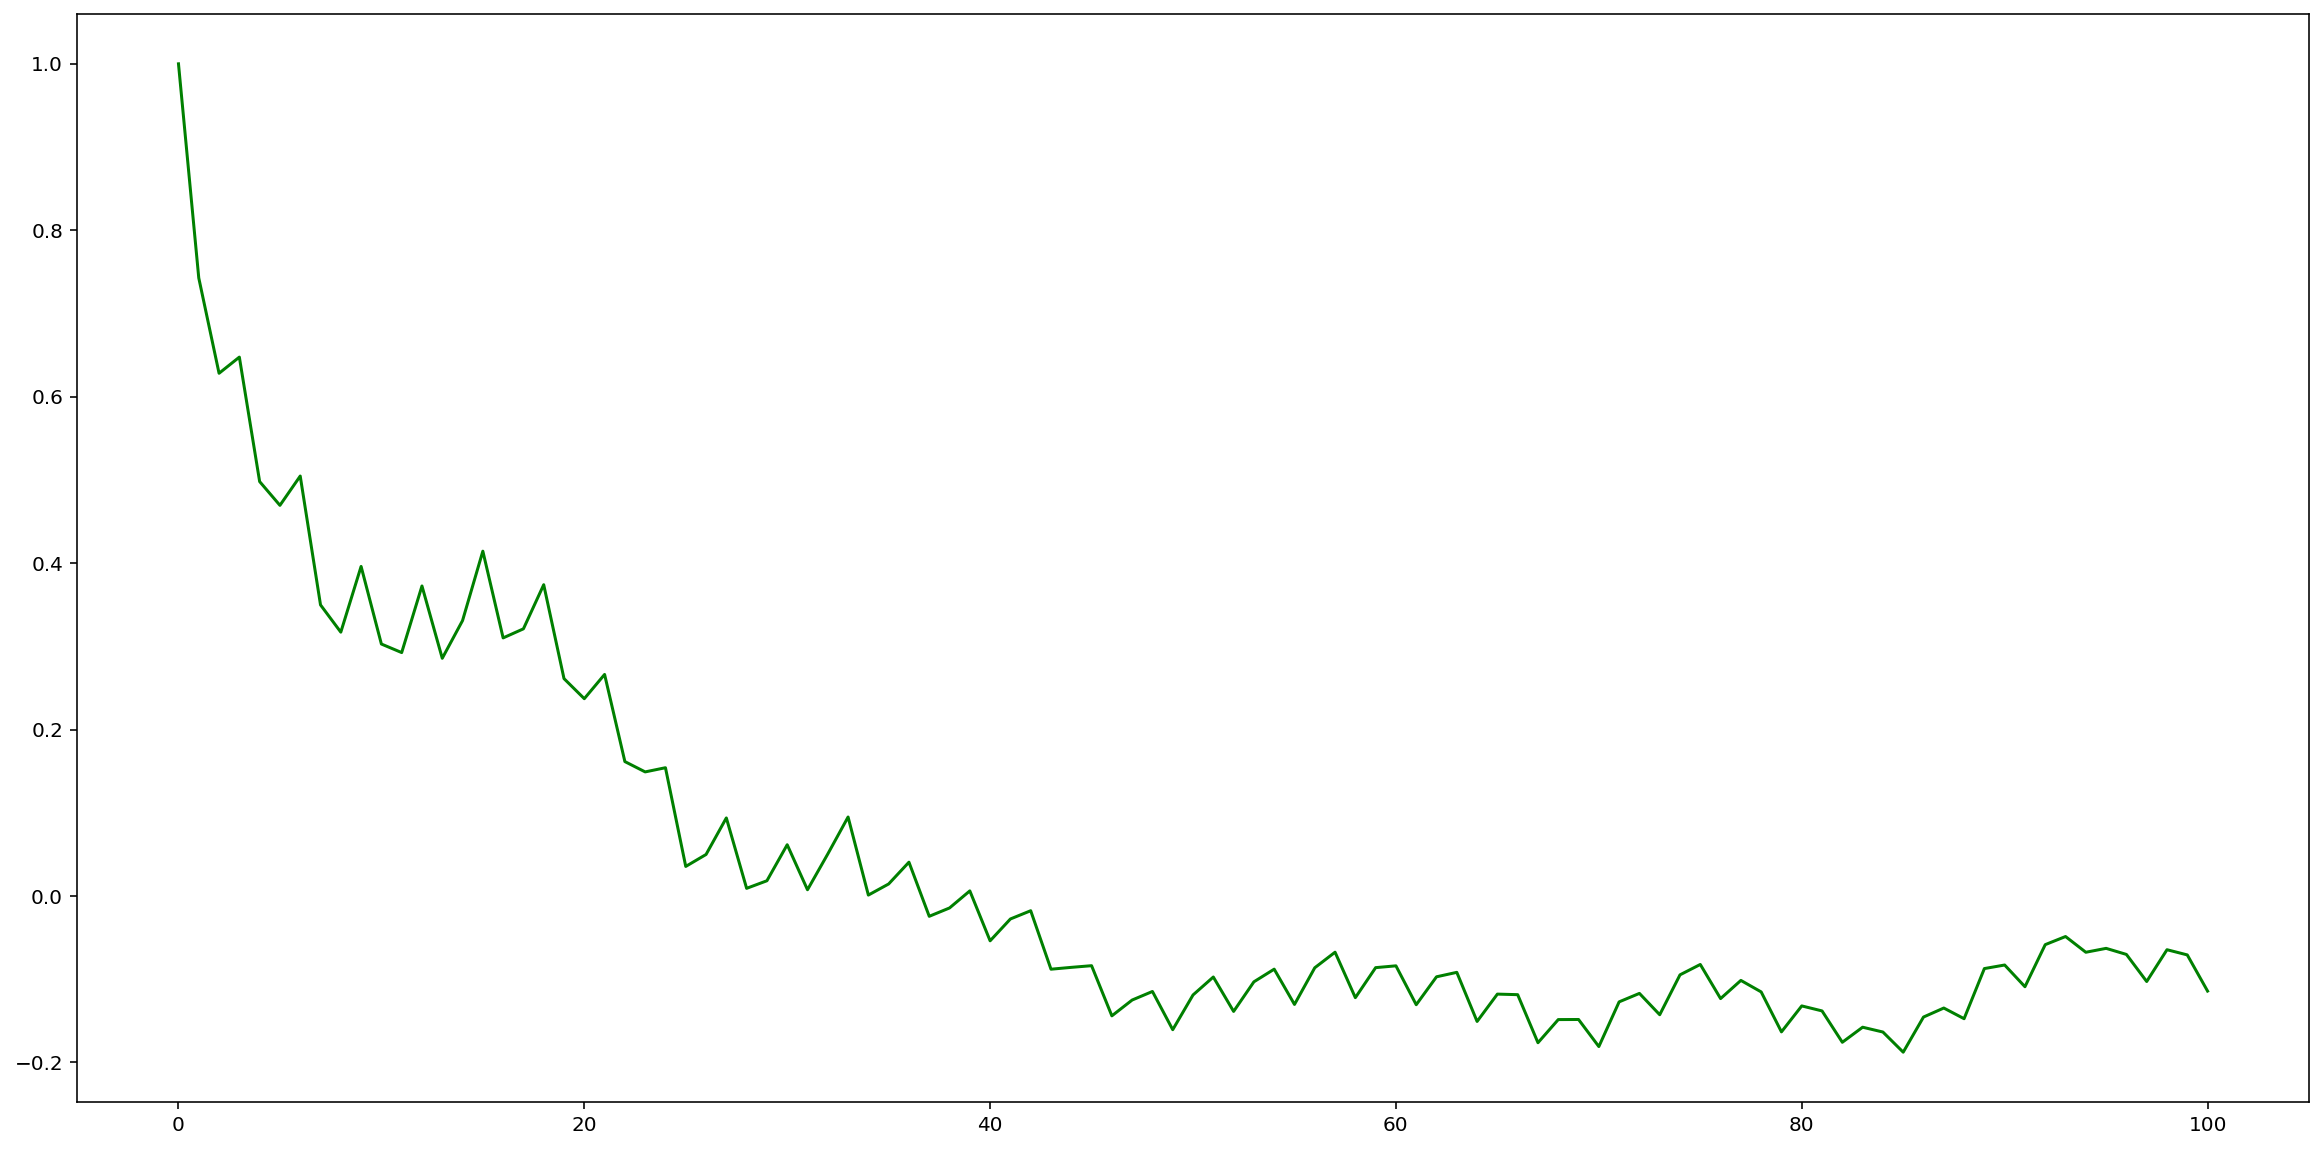

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


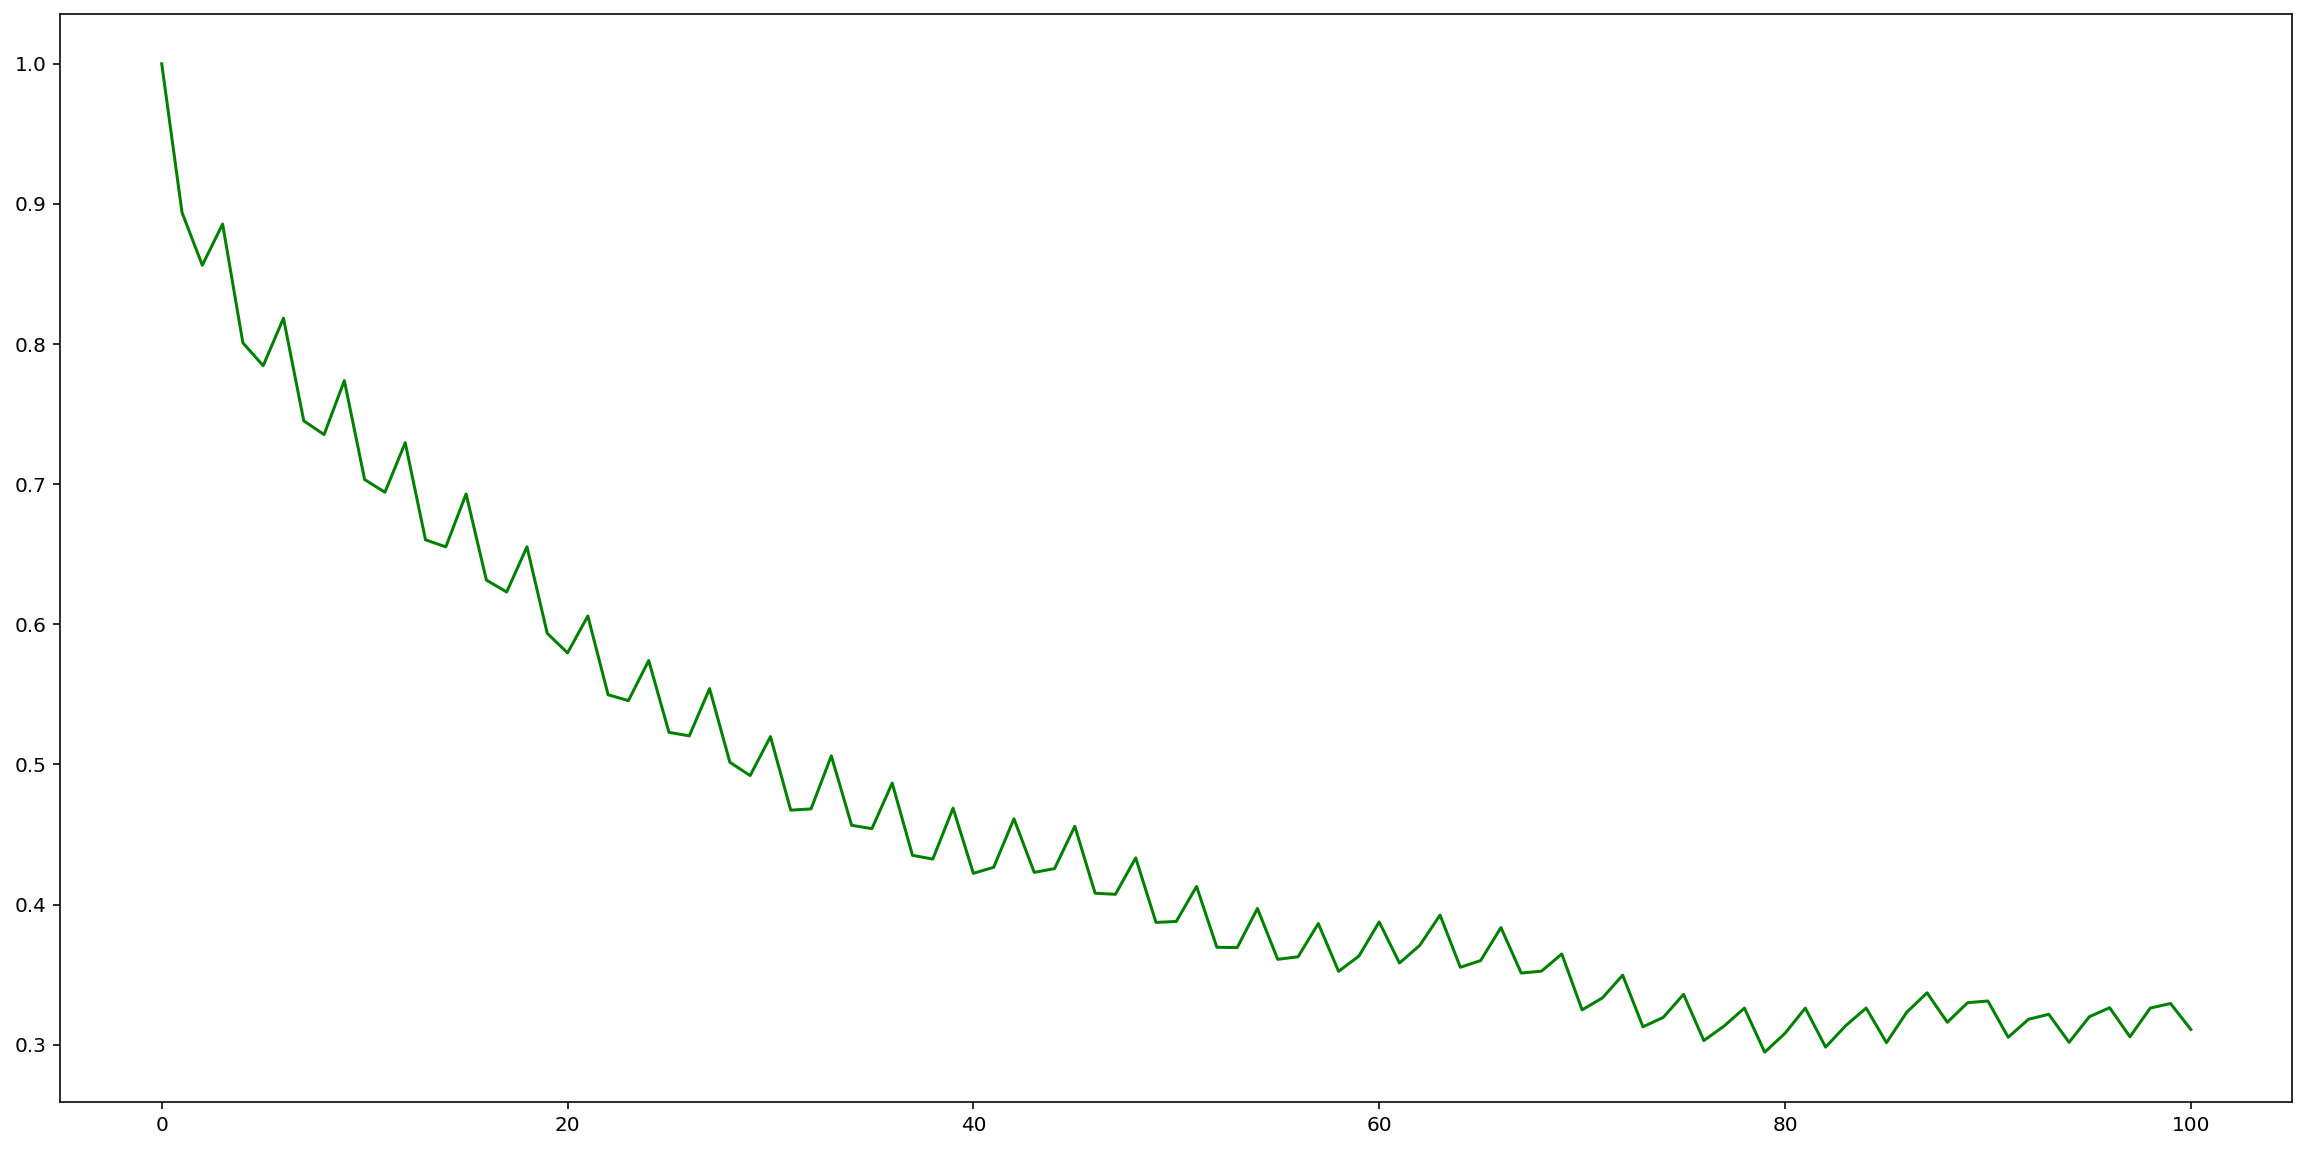

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


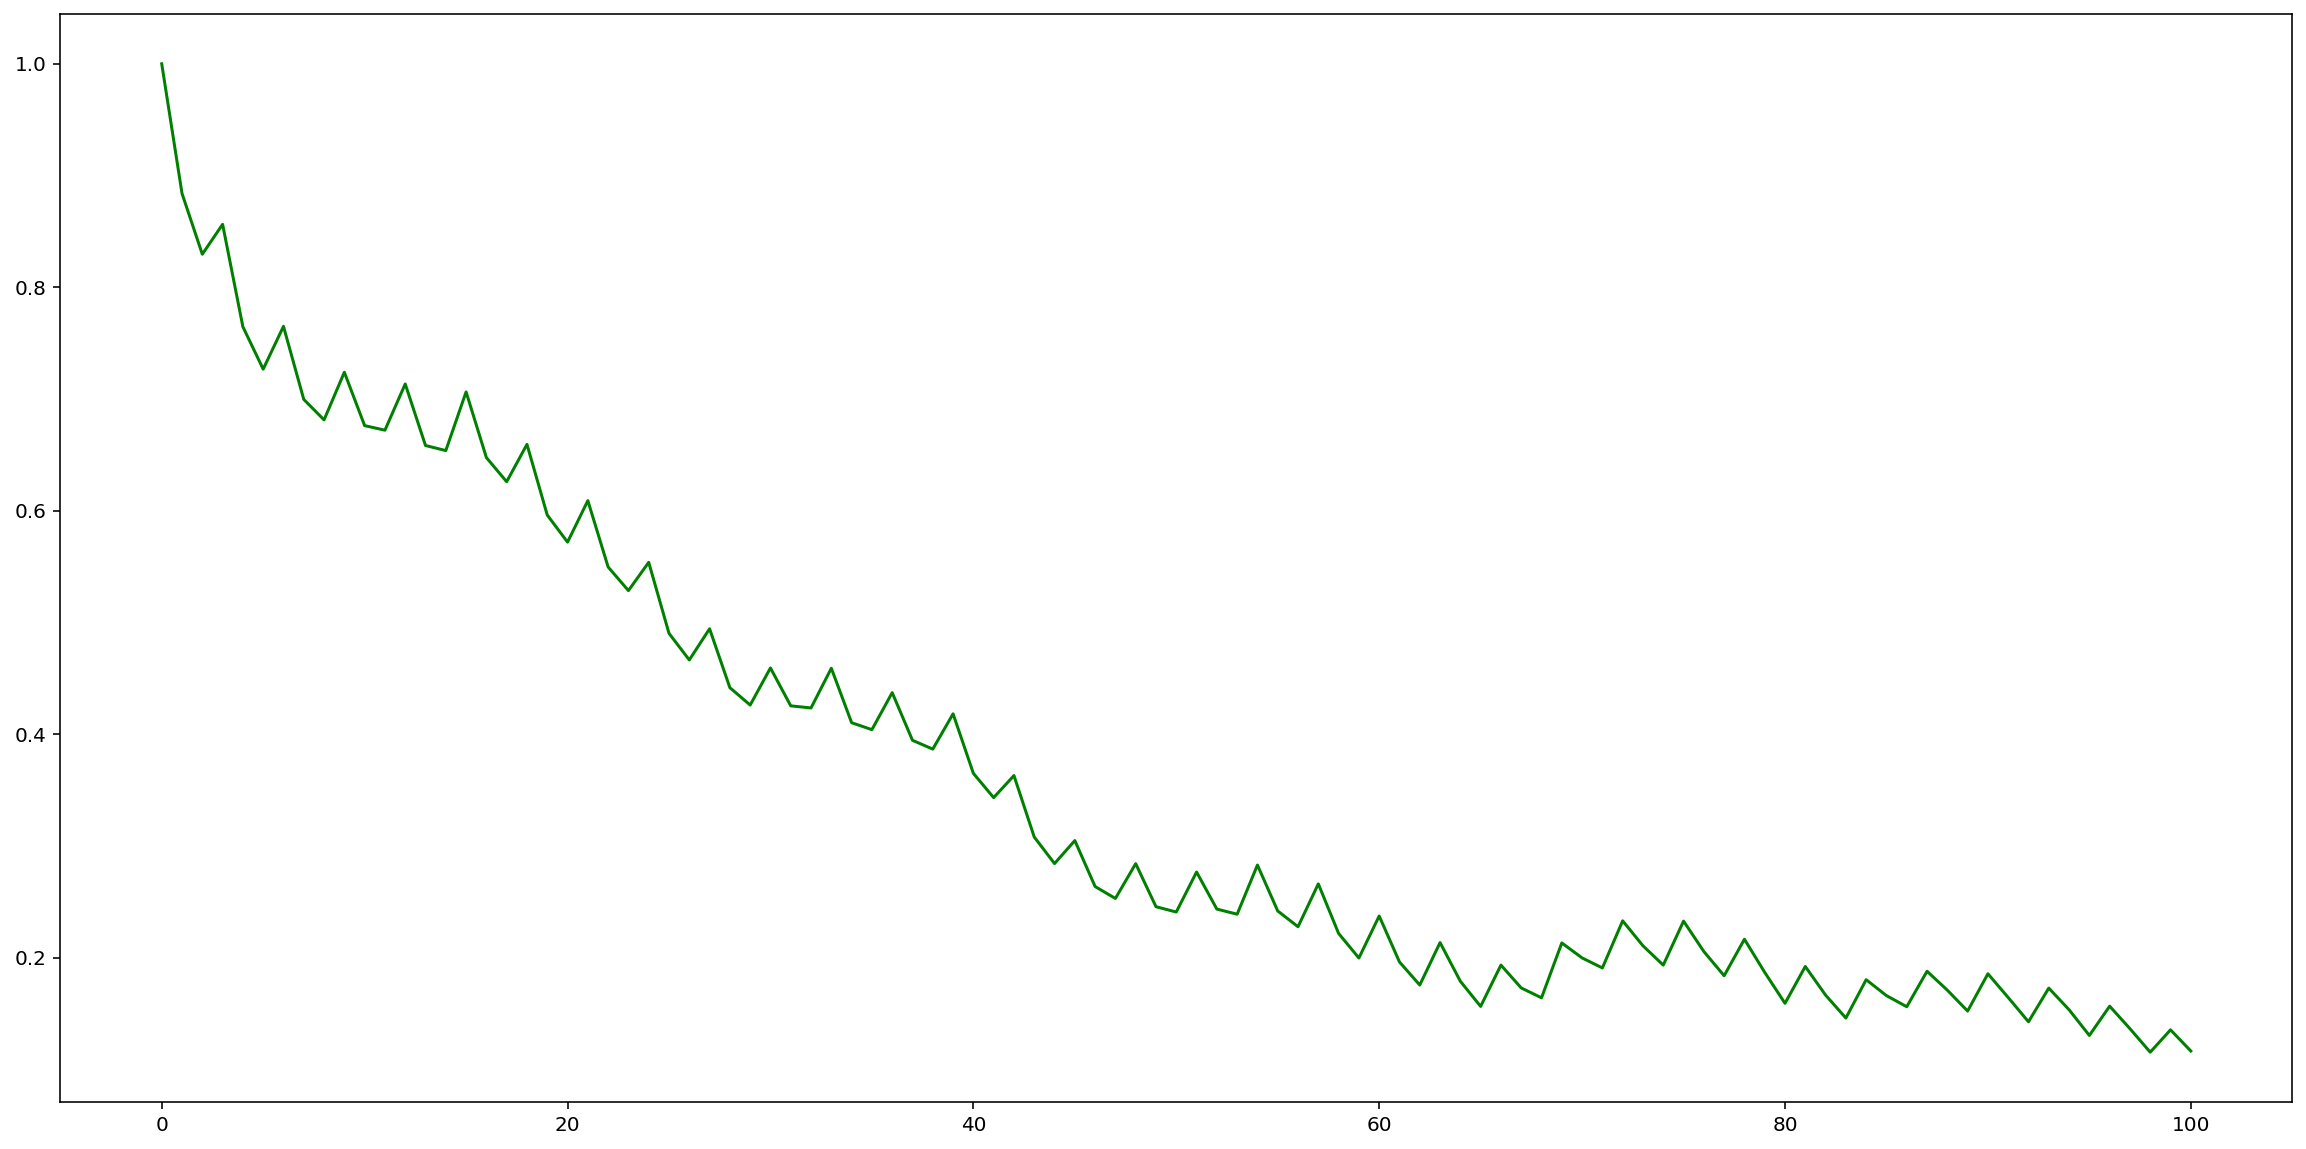

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(acf(y_pred[:,i] - y_hat[:, i], nlags=100), color='green')
    plt.show()

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(scaler.inverse_transform(test_y[:,0:n_features])[:,i], color='green')
    plt.plot(scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])[:,i], color='red')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

RMSE:

In [0]:
np.square(y_hat - y_pred).mean(axis = 0)

array([6.3923583e-04, 2.3500581e-04, 1.6560986e-04, 7.1855561e-06,
       4.9111145e-06, 2.0216475e-04, 5.4807949e-04, 8.7422002e-08,
       1.4632063e-07, 3.0489154e-08, 6.0841408e-06, 4.6262293e-04,
       1.2476095e-05, 2.9321890e-07, 3.0617881e-05], dtype=float32)

In [0]:
np.square(scaler.inverse_transform(test_y[:,0:n_features]) - scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])).mean(axis=0)

array([4.5636278e-03, 1.3131109e-03, 4.0775700e-04, 4.7926460e-05,
       5.9513546e-05, 3.1192724e-03, 3.1446761e-03, 2.1066067e-07,
       1.1445879e-07, 1.0193500e-07, 6.5121385e-05, 1.7009713e-03,
       3.4612164e-04, 3.5528449e-06, 1.6380202e-04], dtype=float32)